**Предсказание температуры стали на металлургическом комбинате «Стальная птица»**

### Введение
В условиях современной промышленности оптимизация производственных затрат является одной из ключевых задач предприятий. Одним из значительных факторов, влияющих на себестоимость продукции, является потребление электроэнергии. Металлургический комбинат «Стальная птица» стремится снизить затраты на электроэнергию при обработке стали, контролируя температуру сплава на различных этапах производства. 

#### Цель проекта
Цель данного проекта – разработка модели машинного обучения, которая будет предсказывать температуру стали в процессе её обработки. Данная модель позволит комбинату более точно регулировать подачу энергии и легирующих добавок, обеспечивая оптимальные условия плавки. В дальнейшем заказчик планирует использовать модель для имитации технологического процесса, что позволит выявить возможности для дальнейшего улучшения производственного цикла.

#### Описание данных
Для реализации проекта используются данные из нескольких источников:

1. Файл `data_arc_new.csv`
- `key` — номер партии;
- `Начало нагрева дугой` — время начала нагрева;
- `Конец нагрева дугой` — время окончания нагрева;
- `Активная мощность` — значение активной мощности;
- `Реактивная мощность` — значение реактивной мощности.

2. Файл `data_bulk_new.csv`
- `key` — номер партии;
- `Bulk 1 … Bulk 15` — объём подаваемого материала.

3. Файл `data_bulk_time_new.csv`
- `key` — номер партии;
- `Bulk 1 … Bulk 15` — время подачи материала.

4. Файл `data_gas_new.csv`
- `key` — номер партии;
- `Газ 1` — объём подаваемого газа.

5. Файл `data_temp_new.csv`
- `key` — номер партии;
- `Время замера` — время замера;
- `Температура` — значение температуры.

6. Файл `data_wire_new.csv`
- `key` — номер партии;
- `Wire 1 … Wire 9` — объём подаваемых проволочных материалов.

7. Файл `data_wire_time_new.csv`
- `key` — номер партии;
- `Wire 1 … Wire 9` — время подачи проволочных материалов.

Во всех файлах столбец **key** содержит номер партии. В файлах может быть несколько строк с одинаковым значением **key**, соответствующих разным итерациям обработки стали.

#### План проекта
1. **Загрузка данных** – первичный осмотр данных.
2. **Исследовательский анализ и предобработка данных** – анализ каждого источника, обработка данных, выделение полезных признаков.
3. **Объединение данных** – формирование единого датафрейма на основе ключевых признаков.
4. **Анализ объединённого датафрейма** – визуализация данных, корреляционный анализ, генерация новых признаков.
5. **Подготовка данных** – разделение выборок, масштабирование, кодирование.
6. **Обучение моделей машинного обучения** – выбор и настройка нескольких моделей.
7. **Выбор лучшей модели** – тестирование и сравнение моделей, выбор оптимального решения.
8. **Общий вывод и рекомендации** – описание ключевых выводов, результаты работы, предложения по внедрению модели.

#### Заключение
Результаты проекта помогут комбинату «Стальная птица» не только сократить энергопотребление, но и повысить стабильность качества продукции, снизить износ оборудования и минимизировать производственные риски.



In [4]:
!pip install shap

In [5]:
!pip install phik

In [6]:
import warnings
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import math

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
simplefilter(action='ignore', category=FutureWarning)

### Загрузка данных

In [8]:
# Пытаемся загрузить все файлы локально
try:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')

# Если ошибка — загружаем файлы по URL
except:
    data_arc_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
    data_wire_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

### Исследовательский анализ и предобработка данных

Создадим функцию для вывода основной информации о датафреймах, которая отображает название датафрейма, первые строки данных для ознакомления, информацию о столбцах, их типах и количестве пропущенных значений, статистическое описание числовых колонок, а также количество дубликатов и пропусков.

In [12]:
def info_df(df):
    # Шаг 1: Вывод первых строк датафрейма
    print("Первые строки датафрейма:")
    display(df.head())
    print(" ")
    
    # Шаг 2: Информация о датафрейме
    print("Информация о датафрейме:")
    display(df.info())
    print(" ")
    
    # Шаг 3: Основные статистики числовых данных
    print("Основные статистики числовых данных:")
    display(df.describe().T)
    print(" ")
    
    # Шаг 4: Количество дубликатов
    print("Количество дубликатов в датафрейме:")
    print(df.duplicated().sum())
    
    # Шаг 5: Количество пропусков
    print("Количество пропусков в датафрейме:")
    print(df.isna().sum())

Создадим функцию для автоматического перебора числовых переменных в датафрейме и построения для каждой из них двух визуализаций: гистограммы и ящика с усами (boxplot).

In [14]:
def numerical_plot(df):
    # Отбираем только числовые столбцы, исключая 'id'
    numeric_df = df.select_dtypes(include='number').drop(columns=['id'], errors='ignore')

    # Для каждого числового столбца строим гистограмму и ящичную диаграмму
    for col in numeric_df.columns:
        fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

        # Гистограмма
        sns.histplot(numeric_df[col], kde=True, ax=axes[0], color='skyblue')
        axes[0].set_title(f'Гистограмма для {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Частота')

        # Ящичная диаграмма
        sns.boxplot(y=numeric_df[col], ax=axes[1], color='lightgreen')
        axes[1].set_title(f'Ящичная диаграмма для {col}')
        axes[1].set_ylabel(col)  # Здесь исправил на ylabel, так как boxplot вертикальный

        plt.tight_layout()  # Корректное расположение графиков
        plt.show()  # Отображение после каждого столбца

Теперь, когда мы создали функции для вывода статистики по числовым переменным и для построения графиков по числовым переменным, применим их поочередно к каждому из наших датафреймов.

Начнём с первичного анализа данных: рассмотрим основные показатели (info, describe, head), проверим количество дубликатов и пропусков, а также визуализируем данные с помощью боксплотов и гистограмм для каждого датафрейма.

---
**data_arc_new**

---

In [19]:
info_df(data_arc_new)

Первые строки датафрейма:


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

 
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

 
Основные статистики числовых данных:


count         mean         std         min         25%  \
key                  14876.0  1615.220422  934.571502    1.000000  806.000000   
Активная мощность    14876.0     0.662752    0.258885    0.223120    0.467115   
Реактивная мощность  14876.0     0.438986    5.873485 -715.479924    0.337175   

                             50%          75%          max  
key                  1617.000000  2429.000000  3241.000000  
Активная мощность       0.599587     0.830070     1.463773  
Реактивная мощность     0.441639     0.608201     1.270284

 
Количество дубликатов в датафрейме:
0
Количество пропусков в датафрейме:
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


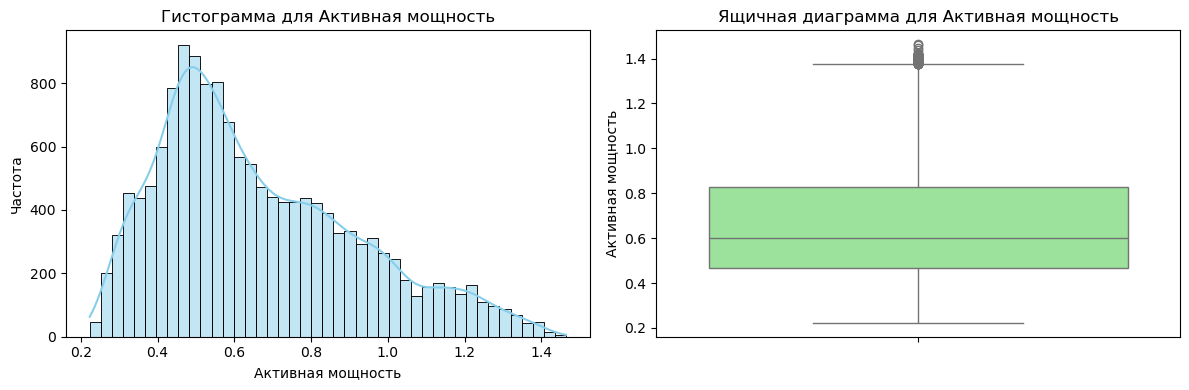

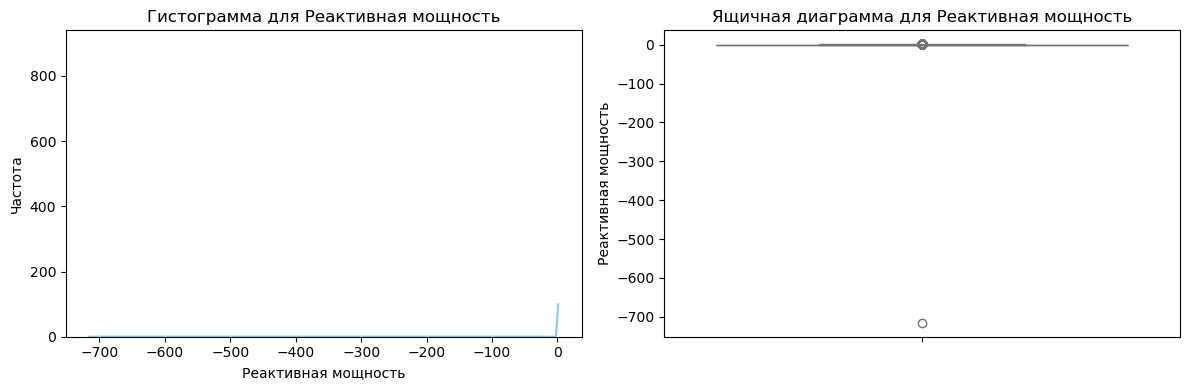

In [20]:
numerical_plot(data_arc_new.drop(columns=["key"]))

В **data_arc_new** 14 876 записей, дубликаты и пропуски отсутствуют,  но для дальнейшего анализа нам будет нужно оставить одну строку для каждого ковша.  

Сначала приведем данные к нужному формату: преобразуем столбцы с началом и концом нагрева дугой в тип `datetime`. Дубликаты и пропуски отсутствуют.  

Затем обработаем выбросы: удалили отрицательное значение реактивной мощности (-715), так как оно противоречит физическим законам.  

Дополнительно создадим новые признаки:  
- **Длительность нагрева** — разница между началом и концом нагрева.  
- **Полная мощность** — рассчитана на основе активной и реактивной мощности.  

In [23]:
data_arc_new = data_arc_new[data_arc_new['Реактивная мощность']>0]

In [26]:
# Преобразуем в формат datetime
data_arc_new["Начало нагрева дугой"] = pd.to_datetime(data_arc_new["Начало нагрева дугой"])
data_arc_new["Конец нагрева дугой"] = pd.to_datetime(data_arc_new["Конец нагрева дугой"])

# Добавляем столбец с длительностью в секундах
data_arc_new["Длительность (сек)"] = (data_arc_new["Конец нагрева дугой"] - data_arc_new["Начало нагрева дугой"]).dt.total_seconds()
# Добавляем столбец с полной мощностью
data_arc_new["Полная мощность"] = np.sqrt(data_arc_new["Активная мощность"]**2 + data_arc_new["Реактивная мощность"]**2)

display(data_arc_new.head())


key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

   Реактивная мощность  Длительность (сек)  Полная мощность  
0             0.211253               228.0         0.371123  
1             0.477438               185.0         0.902319  
2             0.430460               172.0         0.722536  
3             0.379979               365.0         0.642824  
4             0.643691               148.0         1.079934

Проверим, что теперь распределение мощностей корректно:

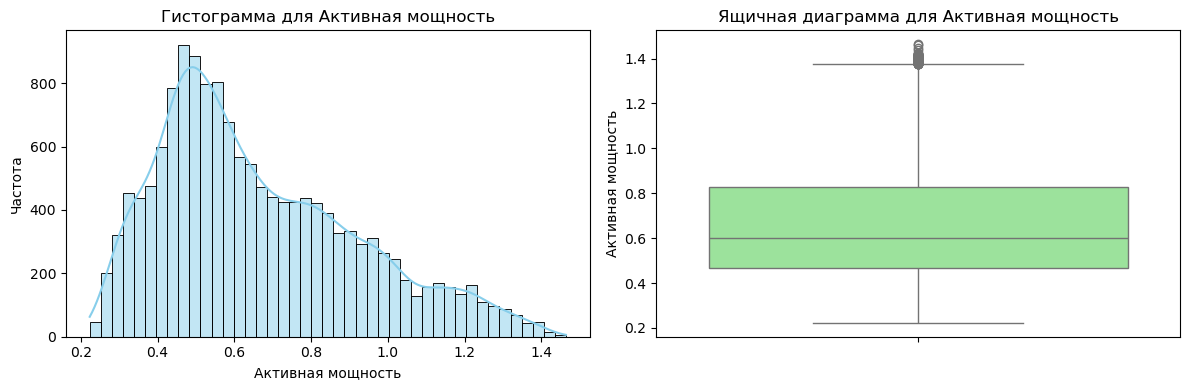

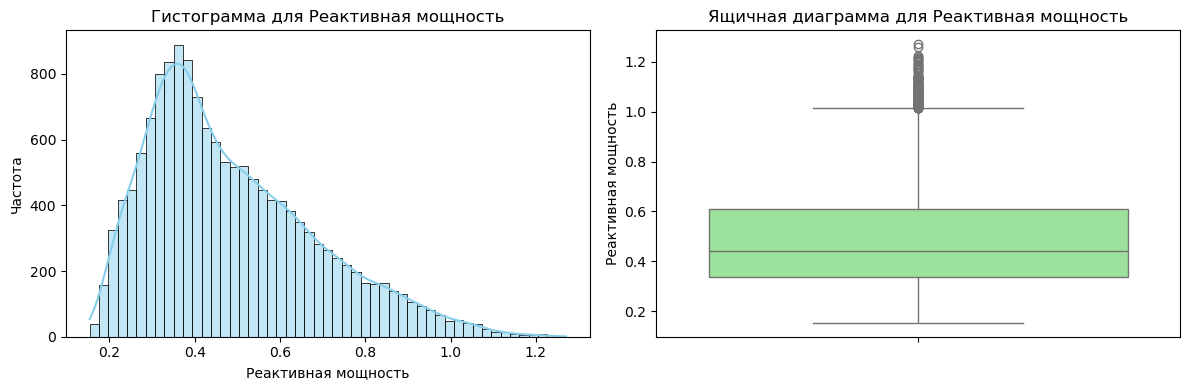

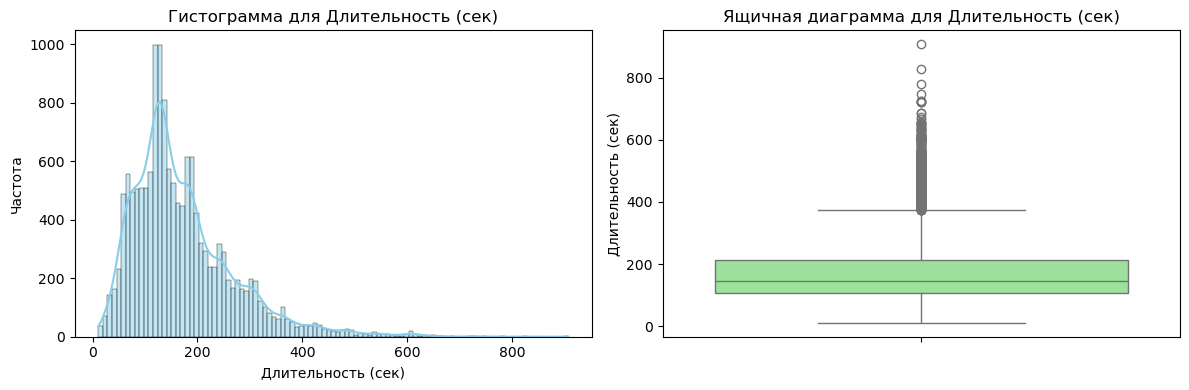

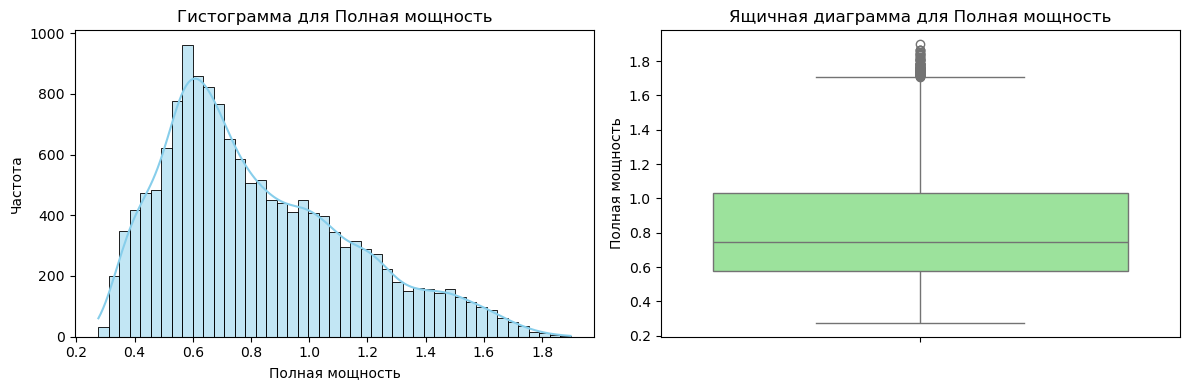

In [29]:
numerical_plot(data_arc_new.drop(columns=["key"]))

Все ошибки исправлены, данные подготовлены. Теперь создаём сводную таблицу, чтобы для каждого ковша осталась одна суммарная строка.

In [31]:
# Создание сводной таблицы с использованием pivot_table
data_arc_pivot = data_arc_new.pivot_table(index="key", values=["Активная мощность", "Реактивная мощность", "Длительность (сек)", "Полная мощность"], aggfunc="sum").reset_index()

display(data_arc_pivot)


key  Активная мощность  Длительность (сек)  Полная мощность  \
0        1           3.036730              1098.0         3.718736   
1        2           2.139408               811.0         2.588349   
2        3           4.063641               655.0         5.019223   
3        4           2.706489               741.0         3.400038   
4        5           2.252950               869.0         2.816980   
...    ...                ...                 ...              ...   
3209  3237           2.541872               909.0         3.250657   
3210  3238           1.374821               546.0         1.723937   
3211  3239           4.848005              1216.0         6.014480   
3212  3240           3.317679               839.0         4.082920   
3213  3241           3.045283               659.0         3.722880   

      Реактивная мощность  
0                2.142821  
1                1.453357  
2                2.937457  
3                2.056992  
4                1.687991  
...                   ...  
3209             2.025417  
3210             1.038103  
3211             3.541541  
3212             2.373552  
3213             2.140011  

[3214 rows x 5 columns]

---
**data_bulk_new**

---

In [34]:
info_df(data_bulk_new)

Первые строки датафрейма:


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

 
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


None

 
Основные статистики числовых данных:


count         mean         std    min     25%     50%      75%  \
key      3129.0  1624.383509  933.337642    1.0  816.00  1622.0  2431.00   
Bulk 1    252.0    39.242063   18.277654   10.0   27.00    31.0    46.00   
Bulk 2     22.0   253.045455   21.180578  228.0  242.00   251.5   257.75   
Bulk 3   1298.0   113.879045   75.483494    6.0   58.00    97.5   152.00   
Bulk 4   1014.0   104.394477   48.184126   12.0   72.00   102.0   133.00   
Bulk 5     77.0   107.025974   81.790646   11.0   70.00    86.0   132.00   
Bulk 6    576.0   118.925347   72.057776   17.0   69.75   100.0   157.00   
Bulk 7     25.0   305.600000  191.022904   47.0  155.00   298.0   406.00   
Bulk 8      1.0    49.000000         NaN   49.0   49.00    49.0    49.00   
Bulk 9     19.0    76.315789   21.720581   63.0   66.00    68.0    70.50   
Bulk 10   176.0    83.284091   26.060347   24.0   64.00    86.5   102.00   
Bulk 11   177.0    76.819209   59.655365    8.0   25.00    64.0   106.00   
Bulk 12  2450.0   260.471020  120.649269   53.0  204.00   208.0   316.00   
Bulk 13    18.0   181.111111   46.088009  151.0  153.25   155.5   203.50   
Bulk 14  2806.0   170.284747   65.868652   16.0  119.00   151.0   205.75   
Bulk 15  2248.0   160.513345   51.765319    1.0  105.00   160.0   205.00   

            max  
key      3241.0  
Bulk 1    185.0  
Bulk 2    325.0  
Bulk 3    454.0  
Bulk 4    281.0  
Bulk 5    603.0  
Bulk 6    503.0  
Bulk 7    772.0  
Bulk 8     49.0  
Bulk 9    147.0  
Bulk 10   159.0  
Bulk 11   313.0  
Bulk 12  1849.0  
Bulk 13   305.0  
Bulk 14   636.0  
Bulk 15   405.0

 
Количество дубликатов в датафрейме:
0
Количество пропусков в датафрейме:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


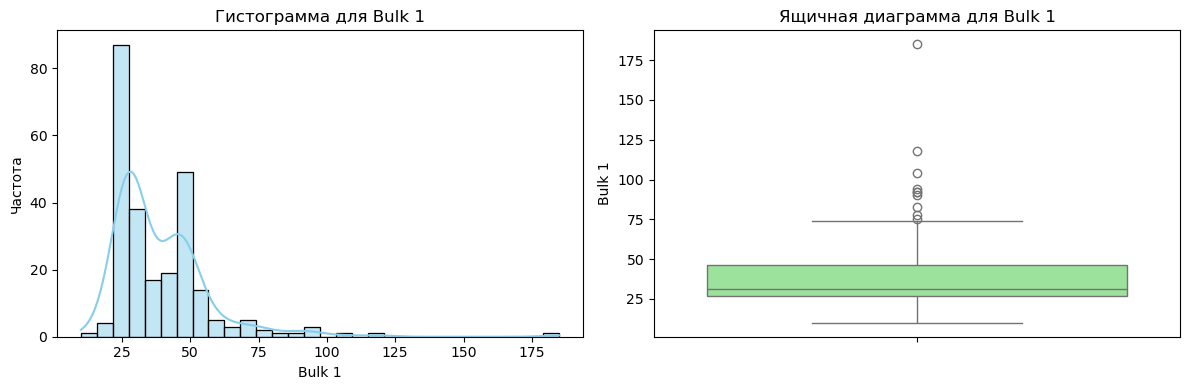

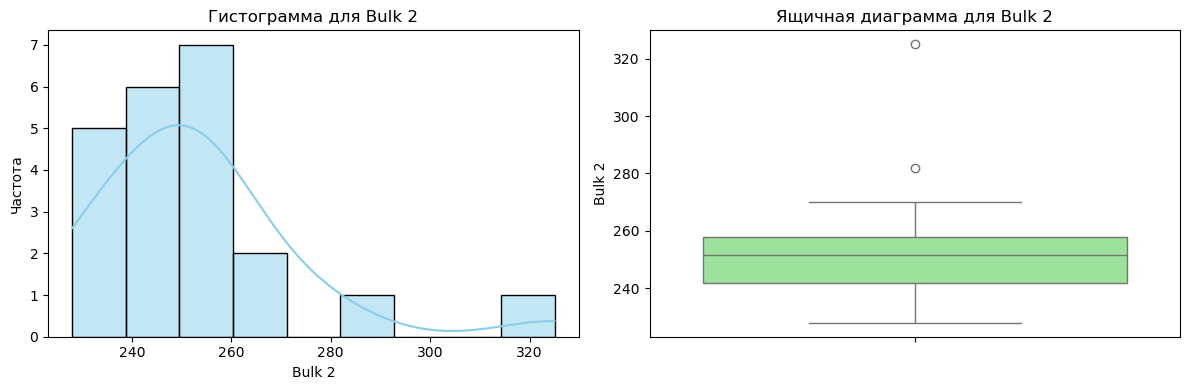

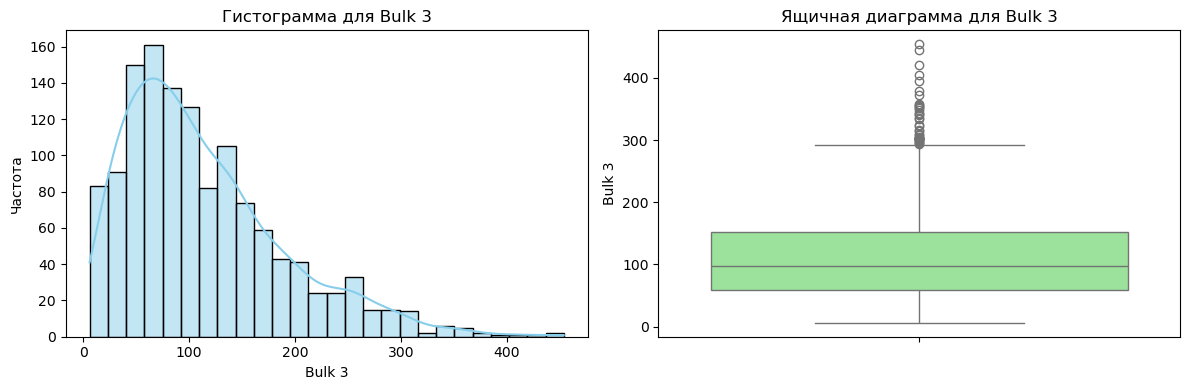

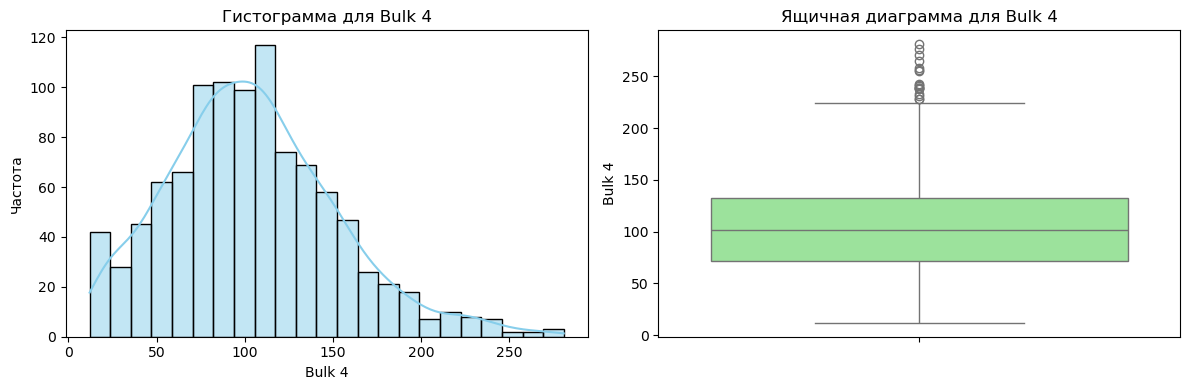

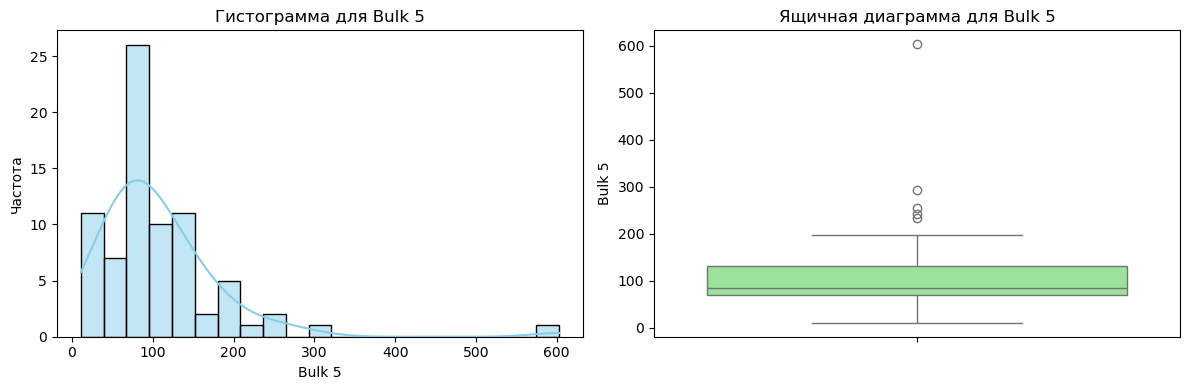

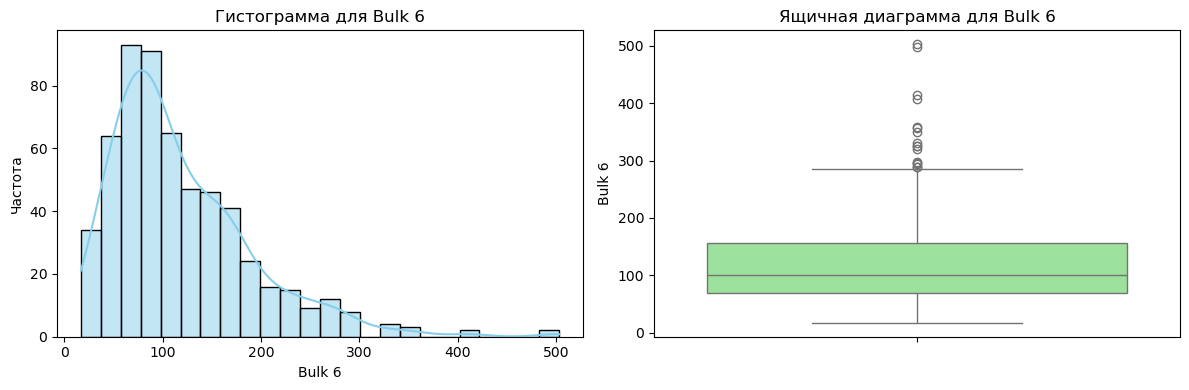

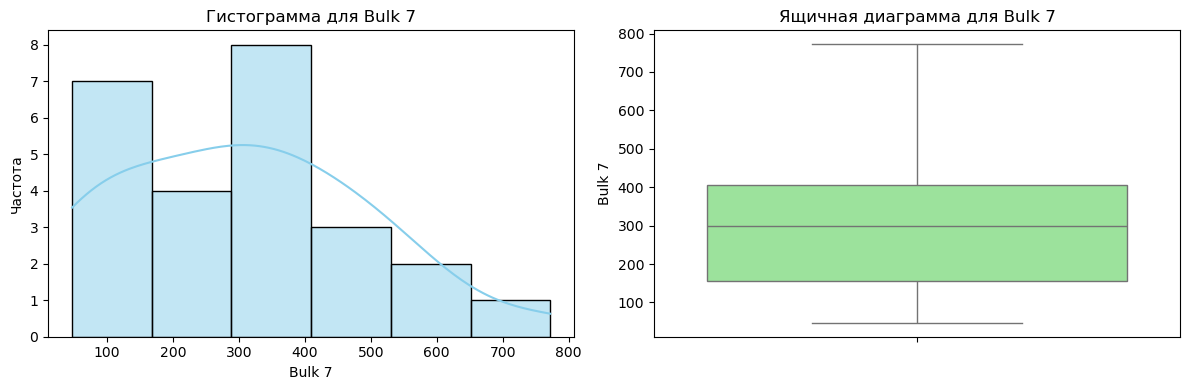

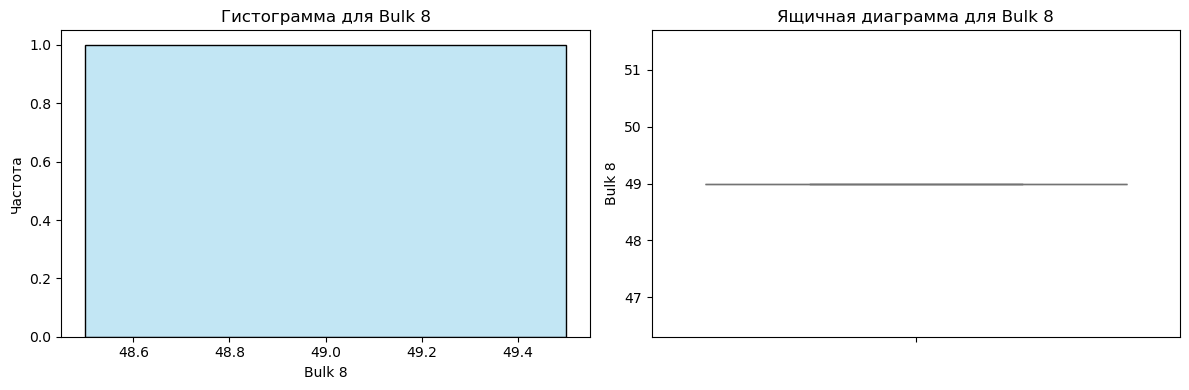

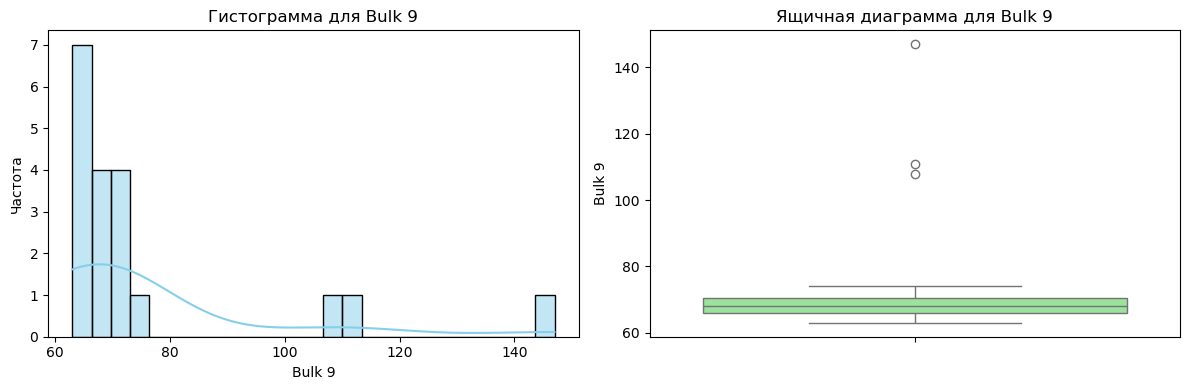

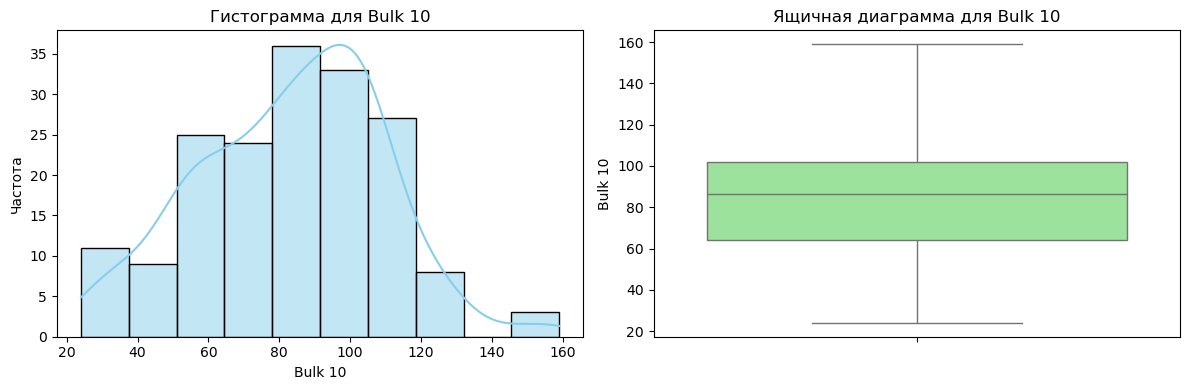

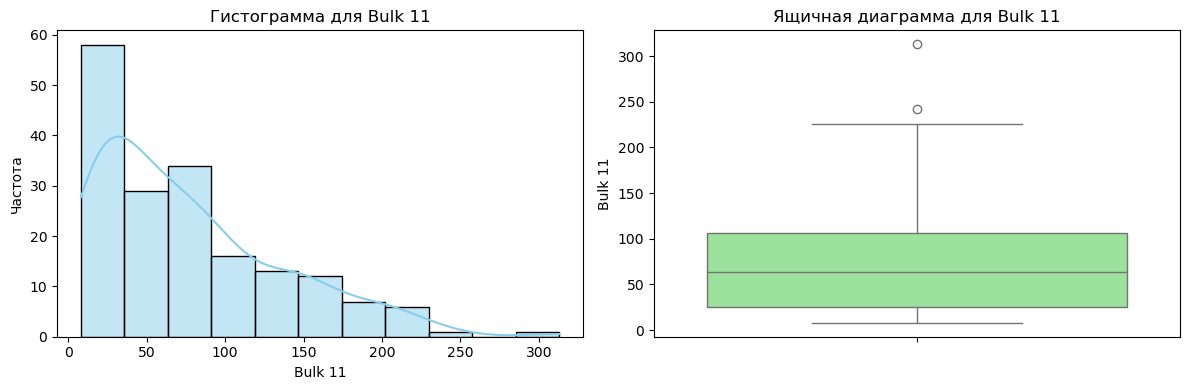

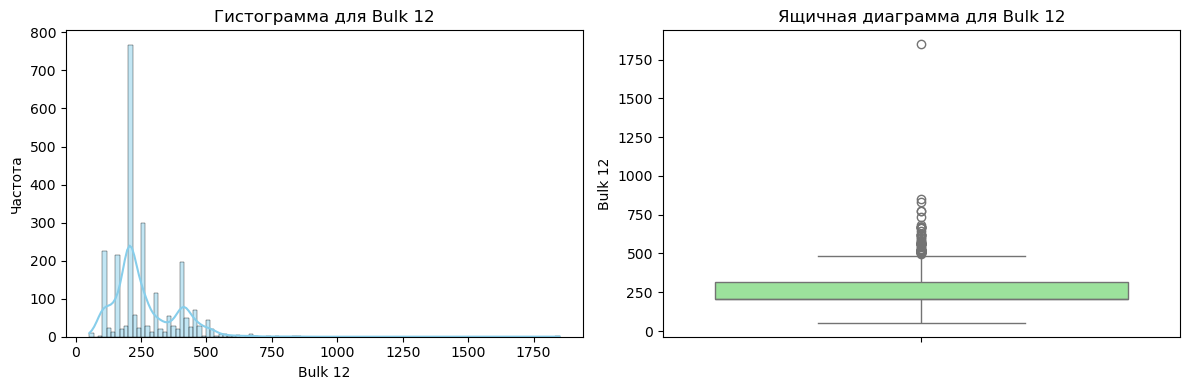

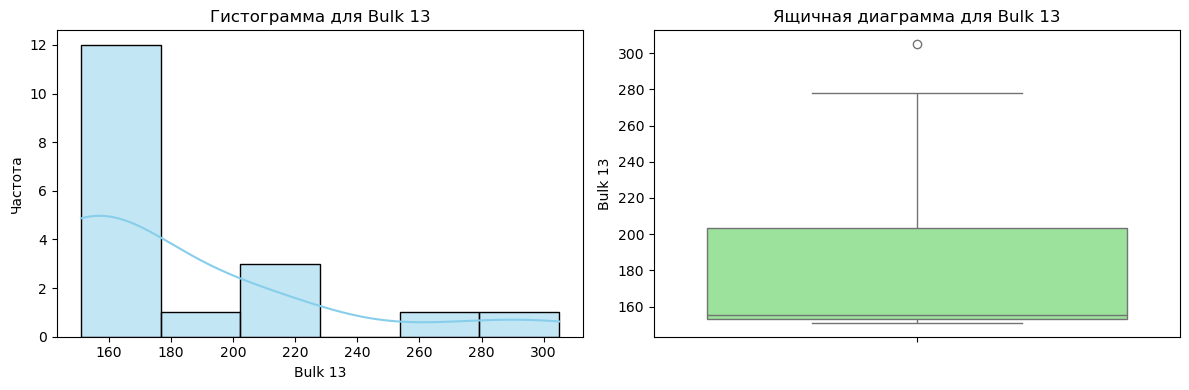

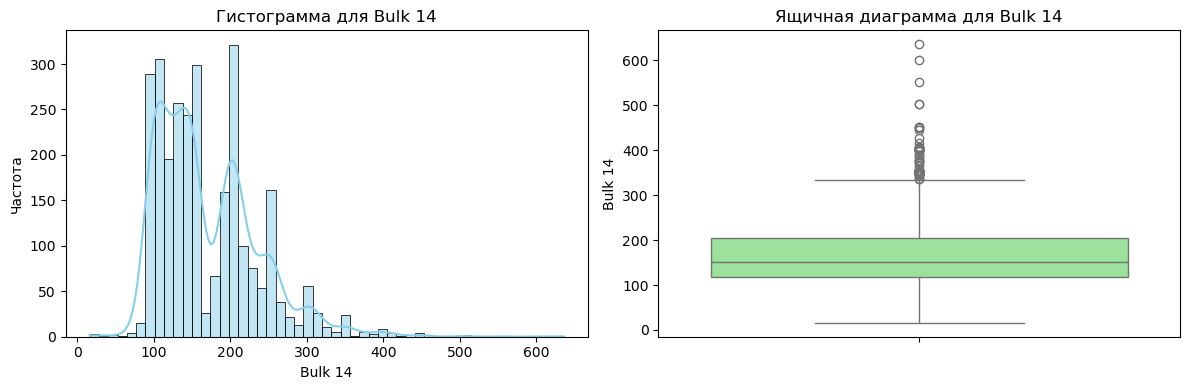

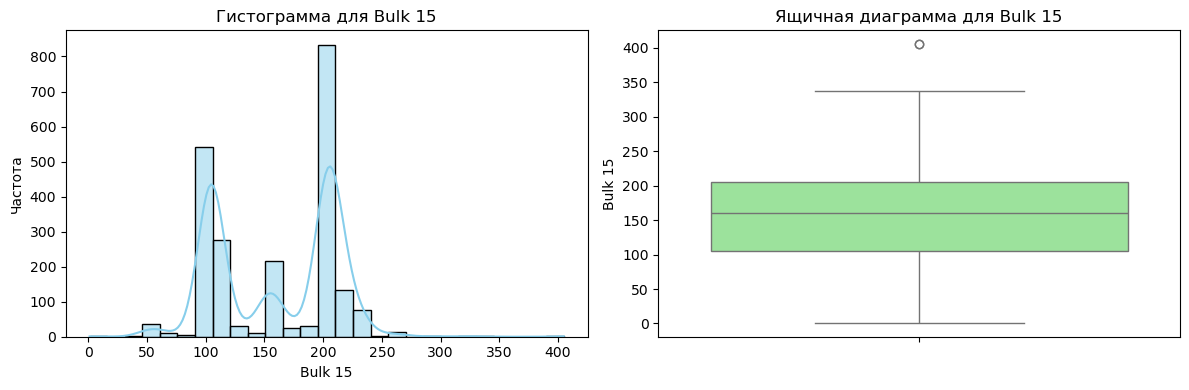

In [35]:
numerical_plot(data_bulk_new.drop(columns=["key"]))

В наборе данных data_bulk_new содержится 3129 уникальных записей, каждая из которых соответствует конкретному ключу (key). Дубликаты данных отсутствуют. Однако в столбцах, представляющих добавки Bulk, наблюдаются пропуски, которые указывают на то, что данная добавка не использовалась для конкретного ковша. Следовательно, пропущенные значения можно безопасно заменить на ноль.

Кроме того, мы наблюдаем, что некоторые виды добавок использовались крайне редко или практически не использовались. Это может повлиять на результаты анализа, и такие добавки стоит либо исключить из исследования, либо обработать отдельно. Для того чтобы изучить частоту использования различных добавок, мы можем воспользоваться дополнительным датафреймом data_bulk_time_new.

In [37]:
data_bulk_new = data_bulk_new.fillna(0)
data_bulk_new.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0  
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0  
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0

---
data_bulk_time_new

---

In [40]:
info_df(data_bulk_time_new)

Первые строки датафрейма:


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

 
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


None

 
Основные статистики числовых данных:


count         mean         std  min    25%     50%     75%     max
key  3129.0  1624.383509  933.337642  1.0  816.0  1622.0  2431.0  3241.0

 
Количество дубликатов в датафрейме:
0
Количество пропусков в датафрейме:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


Таблица data_bulk_time_new (время подачи добавок) полностью идентична по структуре таблице data_bulk_new (объем использованных добавок), и количество записей в них совпадает. Если оставить обе таблицы, то для каждой добавки (Bulk X) появятся два столбца — один с объемом, другой с временем подачи. Это усложнит структуру данных и затруднит анализ, особенно учитывая, что добавки могли вноситься в разное время и не последовательно.

Поэтому логично оставить только таблицу data_bulk_new содержащую объемы,и интегрировать в нее информацию по времени добавок,  а data_bulk_time_new удалить. Теперь определим, какие добавки использовались реже всего, чтобы решить, стоит ли их исключить или обработать отдельно. В качестве порога установим 5% - все, что использовались в менеее чем 5% случаем будем считать редкими случаями.

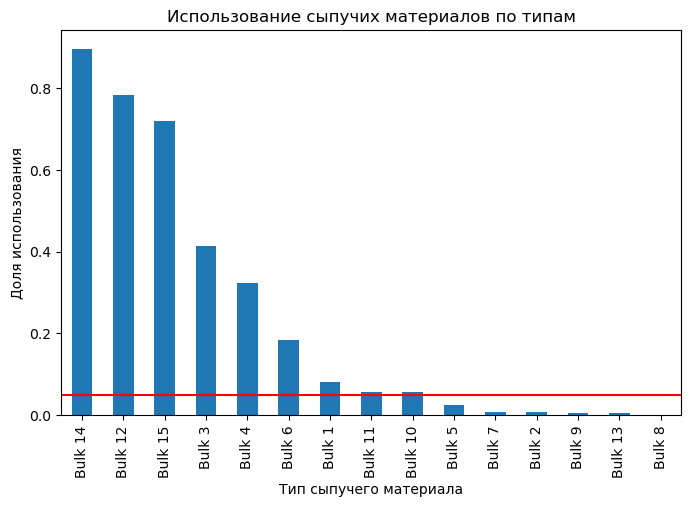

In [43]:
# Убираем столбец 'key'
data_without_key = data_bulk_time_new.drop(columns=['key'], errors='ignore')

# Вычисляем долю использования каждого типа сыпучего материала
usage_ratio = (~data_without_key.isnull()).mean().sort_values(ascending=False)

# Строим столбчатую диаграмму
plt.figure(figsize=(8, 5))
ax = usage_ratio.plot(kind='bar')

# Добавляем горизонтальную линию для выделения 5% от общего количества записей
total_records = len(data_without_key)
threshold = 0.05  # 5% от общего числа
ax.axhline(y=threshold, color='r', linestyle='-')

# Заголовок и подписи для осей
ax.set_title('Использование сыпучих материалов по типам')
ax.set_ylabel('Доля использования')
ax.set_xlabel('Тип сыпучего материала')

# Отображаем график
plt.show()

Мы видим, что добавки bulk 5, 7, 2, 9, 13, 8 использовались менее чем в 5% случаев. Они могут быть излишними для модели, поэтому получим список (чтобы не опираться только на график) таких редких добавок, и объединим их в одну категорию — "Rare", чтобы уменьшить количество малозначимых признаков. Также добавим столбец с общим объемом всех добавок.

In [46]:
rare_additives = usage_ratio[usage_ratio < 0.05].index

# Выводим редкие добавки
print("Редкие добавки (использовались менее чем в 5% случаев):")
print(list(rare_additives))

# Добавляем столбцы 'Rare' и 'Total'
data_bulk_new['Rare'] = data_bulk_new[rare_additives].sum(axis=1)
data_bulk_new = data_bulk_new.drop(columns=rare_additives)
data_bulk_new['Total'] = data_bulk_new.drop(columns=['key', 'Rare'], errors='ignore').sum(axis=1)


Редкие добавки (использовались менее чем в 5% случаев):
['Bulk 5', 'Bulk 7', 'Bulk 2', 'Bulk 9', 'Bulk 13', 'Bulk 8']


Мы не будем дальше использовать `data_bulk_time_new`, так как она дублирует информацию и усложняет структуру данных. Вместо нее добавляем в `data_bulk_new` два новых признака: `bulk_addition_duration` (разница между первым и последним внесением) и `num_bulk_types` (количество уникальных добавок). Это позволяет сохранить важную информацию о процессе без избыточных столбцов. Затем объединяем данные в `data_bulk_combined` в результате данные становятся чище, компактнее и удобнее для анализа.

In [49]:
# Обрабатываем время добавок
data_bulk_time_only = data_bulk_time_new.drop(columns='key', errors='ignore').apply(pd.to_datetime, errors='coerce')
bulk_time_stats = data_bulk_time_new[['key']].copy()
bulk_time_stats['bulk_addition_duration'] = (data_bulk_time_only.max(axis=1) - data_bulk_time_only.min(axis=1)).dt.total_seconds()
bulk_time_stats['num_bulk_types'] = data_bulk_time_only.notna().sum(axis=1)

# Объединяем данные
data_bulk_combined = data_bulk_new.merge(bulk_time_stats, on='key', how='left')

# Выводим результат
display(data_bulk_combined.head())

key  Bulk 1  Bulk 3  Bulk 4  Bulk 6  Bulk 10  Bulk 11  Bulk 12  Bulk 14  \
0    1     0.0     0.0    43.0     0.0      0.0      0.0    206.0    150.0   
1    2     0.0     0.0    73.0     0.0      0.0      0.0    206.0    149.0   
2    3     0.0     0.0    34.0     0.0      0.0      0.0    205.0    152.0   
3    4     0.0     0.0    81.0     0.0      0.0      0.0    207.0    153.0   
4    5     0.0     0.0    78.0     0.0      0.0      0.0    203.0    151.0   

   Bulk 15  Rare  Total  bulk_addition_duration  num_bulk_types  
0    154.0   0.0  553.0                  1085.0               4  
1    154.0   0.0  582.0                  1000.0               4  
2    153.0   0.0  544.0                   983.0               4  
3    154.0   0.0  595.0                   878.0               4  
4    152.0   0.0  584.0                   205.0               4

---
**data_gas_new**

---

In [52]:
info_df(data_gas_new)

Первые строки датафрейма:


key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

 
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

 
Основные статистики числовых данных:


count         mean         std       min         25%          50%  \
key    3239.0  1621.861377  935.386334  1.000000  812.500000  1622.000000   
Газ 1  3239.0    11.002062    6.220327  0.008399    7.043089     9.836267   

               75%         max  
key    2431.500000  3241.00000  
Газ 1    13.769915    77.99504

 
Количество дубликатов в датафрейме:
0
Количество пропусков в датафрейме:
key      0
Газ 1    0
dtype: int64


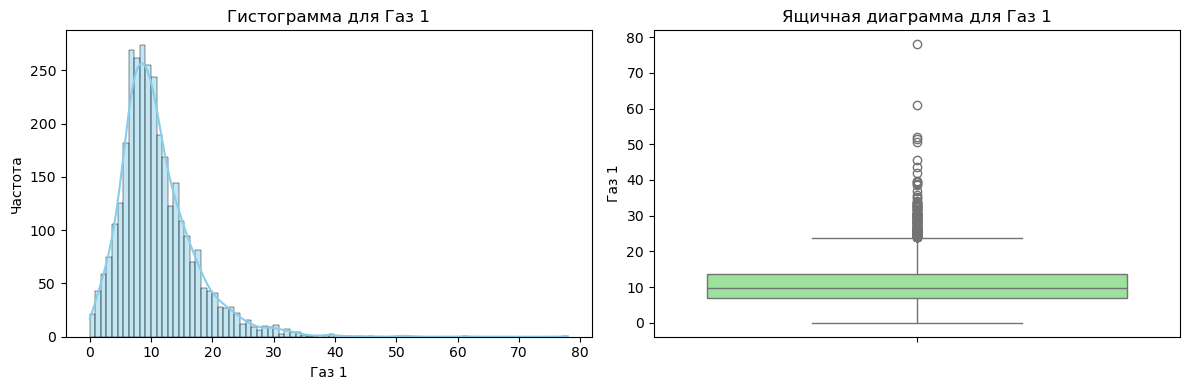

In [53]:
numerical_plot(data_gas_new.drop(columns=["key"]))

В таблице data_gas_new содержится 3239 записей, дубликатов и пропусков нет. Медианное значение для газа 1 составляет 9,83. Хотя в данных присутствуют выбросы в диапазоне от 30 до 80, они могут быть значимыми для производственного процесса, поэтому решено оставить их в данных. Никаких изменений в удалении или добавлении признаков производить не будем.

---
**data_temp_new**

---

In [57]:
info_df(data_temp_new)

Первые строки датафрейма:


key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

 
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

 
Основные статистики числовых данных:


count         mean         std     min      25%     50%  \
key          18092.0  1616.460977  934.641385     1.0   807.75  1618.0   
Температура  14665.0  1590.722741   20.394381  1191.0  1580.00  1590.0   

                75%     max  
key          2429.0  3241.0  
Температура  1599.0  1705.0

 
Количество дубликатов в датафрейме:
0
Количество пропусков в датафрейме:
key                0
Время замера       0
Температура     3427
dtype: int64


Минимальная зафиксированная температура составляет 1191°C, что значительно ниже ожидаемых значений. Согласно вводным данным от заказчика, температуры ниже 1400°C считаются аномальными. Поэтому такие значения исключаем, чтобы избежать искажений в анализе.

In [59]:
data_temp_new = data_temp_new[data_temp_new['Температура'] > 1400]

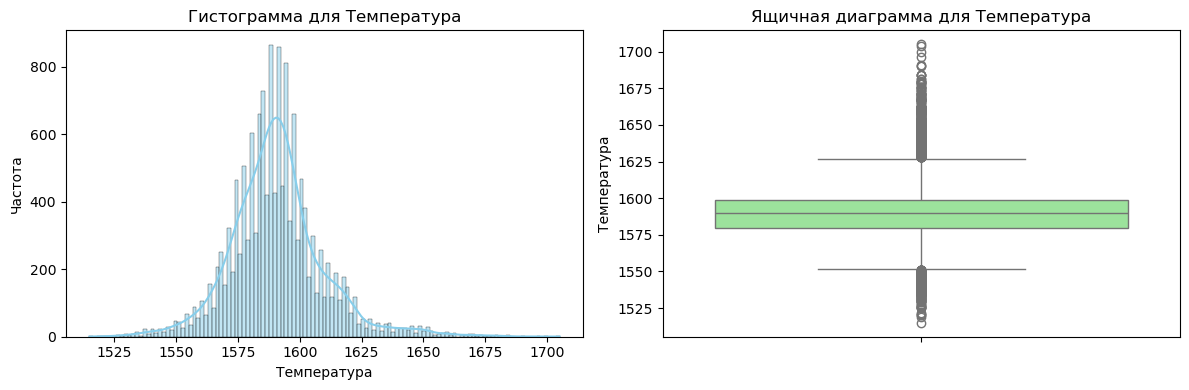

In [62]:
numerical_plot(data_temp_new.drop(columns=["key"]))

Файл `data_temp_new` содержит 18 092 записи. Медианное значение температуры — около 1590°C. На графике с усами заметны участки уплотнения данных в диапазонах 1500–1550°C и 1630–1700°C, что может указывать на особенности технологического процесса или систематические колебания в измерениях.
Для каждого ковша зафиксировано несколько строк, так как температура измерялась несколько раз. Однако мы обнаружили, что начиная с 10 августа в части ковшей отсутствует финальная температура: есть данные о начале процесса и времени замеров, но финального значения нет.  

Поскольку **целевой показатель в задаче — именно финальная температура**, нам нужно оставить только те ковши, для которых было как минимум три замера: начальный, промежуточный и финальный. Ковши с пропусками не подходят, так как без финального значения мы не сможем корректно оценить качество модели. Возможные причины отсутствующих данных: технические сбои или неизменность температуры, но в любом случае такие записи следует исключить.  

---
Этапы очистки и подготовки данных:  
1. **Преобразование времени замеров в `datetime`** – это необходимо для корректной работы с временными интервалами.  
2. **Добавление индикатора “Итерация”** – он позволит определить порядок замеров для каждого ковша и выделить начальную и финальную температуры.  
3. **Фильтрация ковшей** – исключаем записи, если:\n   - есть только один замер,\n   - отсутствуют данные на старте или в конце процесса.  
4. **Оставляем только ковши с полными данными** – это обеспечит точность анализа.  
5. **Фиксация стартовой и финальной температуры** – также рассчитываем временные интервалы между замерами, чтобы анализировать динамику нагрева.  

В результате мы получаем чистый, структурированный набор данных, в котором для каждого ковша остаётся одна строка с ключевыми параметрами. Это позволит строить более надёжную модель и получать точные прогнозы. 

In [65]:
# Преобразуем столбец 'Время замера' в тип datetime
data_temp_new['Время замера'] = pd.to_datetime(data_temp_new['Время замера'])

# Добавляем индекс замера для каждого key
data_temp_new['Итерация'] = data_temp_new.groupby('key').cumcount() + 1

# Фильтрация ковшей с достаточным количеством замеров
valid_keys = data_temp_new.groupby('key').filter(lambda x: x['Температура'].notna().sum() >= 2)['key'].unique()

# Отфильтруем данные, оставив только ковши, которые соответствуют условиям
filtered_data = data_temp_new[data_temp_new['key'].isin(valid_keys)]

# Группируем данные по 'key' и вычисляем промежуток между замерами, стартовую и финальную температуру
result_data = filtered_data.groupby('key').agg(
    Промежуток_между_замерами=('Время замера', lambda x: (x.max() - x.min()).total_seconds()),
    Температура_на_старте=('Температура', 'first'),
    Финальная_температура=('Температура', 'last')
).reset_index()

# Выводим результат
display(result_data.head(20))

key  Промежуток_между_замерами  Температура_на_старте  \
0     1                     1714.0                 1571.0   
1     2                     1265.0                 1581.0   
2     3                     1753.0                 1596.0   
3     4                     1220.0                 1601.0   
4     5                     1536.0                 1576.0   
5     6                     1497.0                 1543.0   
6     7                     1744.0                 1586.0   
7     8                     1615.0                 1577.0   
8     9                     1811.0                 1587.0   
9    10                     1551.0                 1574.0   
10   11                     2836.0                 1616.0   
11   12                     2488.0                 1606.0   
12   13                     1989.0                 1596.0   
13   14                     2717.0                 1583.0   
14   15                     2759.0                 1605.0   
15   16                     2131.0                 1581.0   
16   17                     2048.0                 1611.0   
17   18                     3373.0                 1588.0   
18   19                     2737.0                 1625.0   
19   20                     2153.0                 1582.0   

    Финальная_температура  
0                  1613.0  
1                  1602.0  
2                  1599.0  
3                  1625.0  
4                  1602.0  
5                  1596.0  
6                  1599.0  
7                  1598.0  
8                  1592.0  
9                  1593.0  
10                 1597.0  
11                 1591.0  
12                 1619.0  
13                 1606.0  
14                 1598.0  
15                 1607.0  
16                 1599.0  
17                 1595.0  
18                 1597.0  
19                 1603.0

In [66]:
display(result_data.tail(20))

key  Промежуток_между_замерами  Температура_на_старте  \
2455  2479                     1235.0                 1576.0   
2456  2480                     1740.0                 1556.0   
2457  2481                     1590.0                 1559.0   
2458  2482                     1655.0                 1569.0   
2459  2483                     2191.0                 1598.0   
2460  2484                      814.0                 1635.0   
2461  2485                     2277.0                 1582.0   
2462  2486                      458.0                 1589.0   
2463  2487                     2502.0                 1568.0   
2464  2488                     2735.0                 1602.0   
2465  2489                      802.0                 1613.0   
2466  2490                     2334.0                 1602.0   
2467  2492                     2438.0                 1618.0   
2468  2493                     1863.0                 1599.0   
2469  2494                      905.0                 1585.0   
2470  2495                     1380.0                 1570.0   
2471  2496                     1705.0                 1554.0   
2472  2497                      962.0                 1571.0   
2473  2498                     1520.0                 1591.0   
2474  2499                     1537.0                 1569.0   

      Финальная_температура  
2455                 1601.0  
2456                 1595.0  
2457                 1598.0  
2458                 1598.0  
2459                 1598.0  
2460                 1592.0  
2461                 1616.0  
2462                 1592.0  
2463                 1583.0  
2464                 1577.0  
2465                 1579.0  
2466                 1619.0  
2467                 1595.0  
2468                 1594.0  
2469                 1591.0  
2470                 1591.0  
2471                 1591.0  
2472                 1589.0  
2473                 1594.0  
2474                 1603.0

In [67]:
result_data

key  Промежуток_между_замерами  Температура_на_старте  \
0        1                     1714.0                 1571.0   
1        2                     1265.0                 1581.0   
2        3                     1753.0                 1596.0   
3        4                     1220.0                 1601.0   
4        5                     1536.0                 1576.0   
...    ...                        ...                    ...   
2470  2495                     1380.0                 1570.0   
2471  2496                     1705.0                 1554.0   
2472  2497                      962.0                 1571.0   
2473  2498                     1520.0                 1591.0   
2474  2499                     1537.0                 1569.0   

      Финальная_температура  
0                    1613.0  
1                    1602.0  
2                    1599.0  
3                    1625.0  
4                    1602.0  
...                     ...  
2470                 1591.0  
2471                 1591.0  
2472                 1589.0  
2473                 1594.0  
2474                 1603.0  

[2475 rows x 4 columns]

---
**data_wire_new**

---

In [72]:
info_df(data_wire_new)

Первые строки датафрейма:


key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

 
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

 
Основные статистики числовых данных:


count         mean         std        min         25%          50%  \
key     3081.0  1623.426485  932.996726   1.000000  823.000000  1619.000000   
Wire 1  3055.0   100.895853   42.012518   1.918800   72.115684   100.158234   
Wire 2  1079.0    50.577323   39.320216   0.030160   20.193680    40.142956   
Wire 3    63.0   189.482681   99.513444   0.144144   95.135044   235.194977   
Wire 4    14.0    57.442841   28.824667  24.148801   40.807002    45.234282   
Wire 5     1.0    15.132000         NaN  15.132000   15.132000    15.132000   
Wire 6    73.0    48.016974   33.919845   0.034320   25.053600    42.076324   
Wire 7    11.0    10.039007    8.610584   0.234208    6.762756     9.017009   
Wire 8    19.0    53.625193   16.881728  45.076721   46.094879    46.279999   
Wire 9    29.0    34.155752   19.931616   4.622800   22.058401    30.066399   

                75%          max  
key     2434.000000  3241.000000  
Wire 1   126.060483   330.314424  
Wire 2    70.227558   282.780152  
Wire 3   276.252014   385.008668  
Wire 4    76.124619   113.231044  
Wire 5    15.132000    15.132000  
Wire 6    64.212723   180.454575  
Wire 7    11.886057    32.847674  
Wire 8    48.089603   102.762401  
Wire 9    43.862003    90.053604

 
Количество дубликатов в датафрейме:
0
Количество пропусков в датафрейме:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


In [73]:
data_wire_new = data_wire_new.fillna(0)
data_wire_new.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1    2  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    3  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    4  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    5  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

   Wire 9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

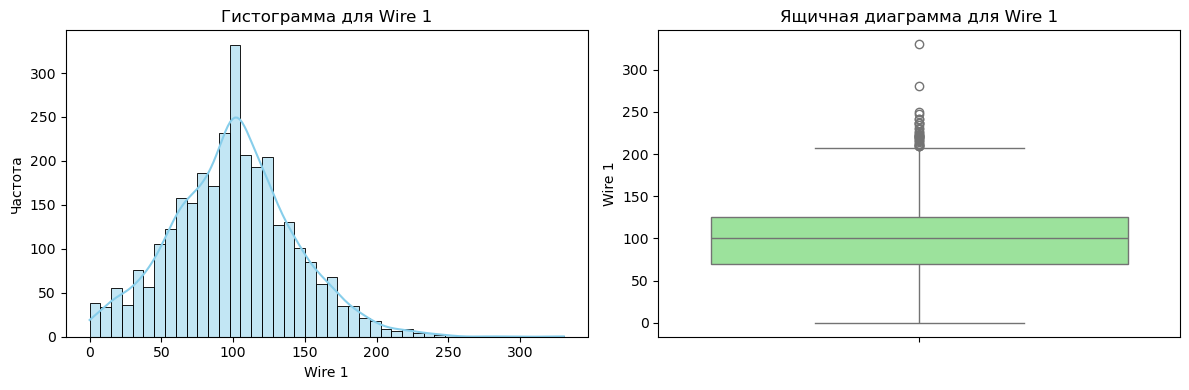

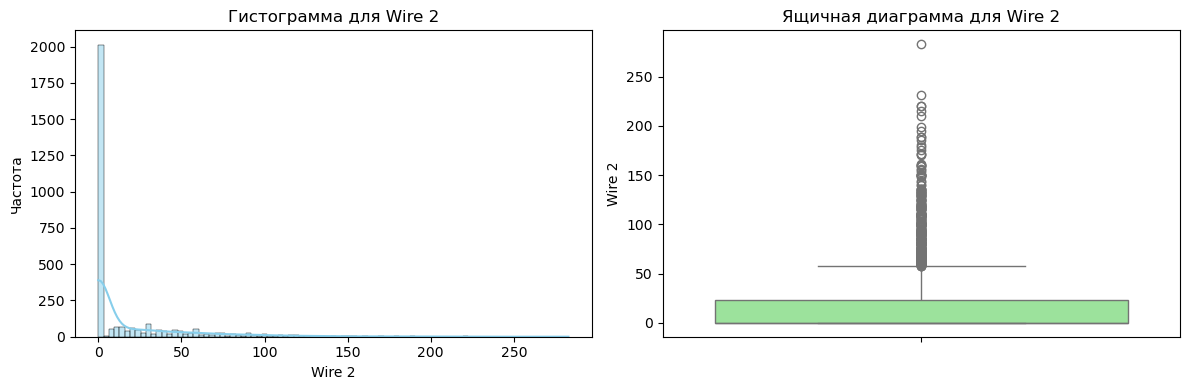

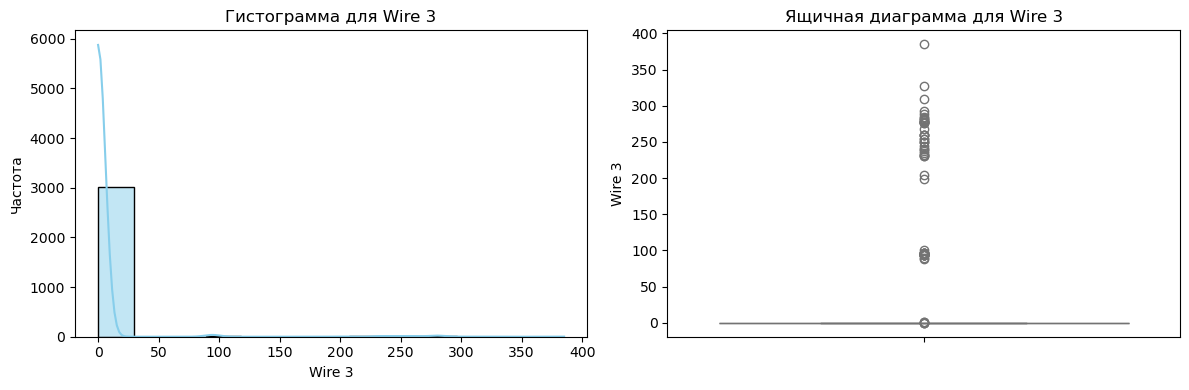

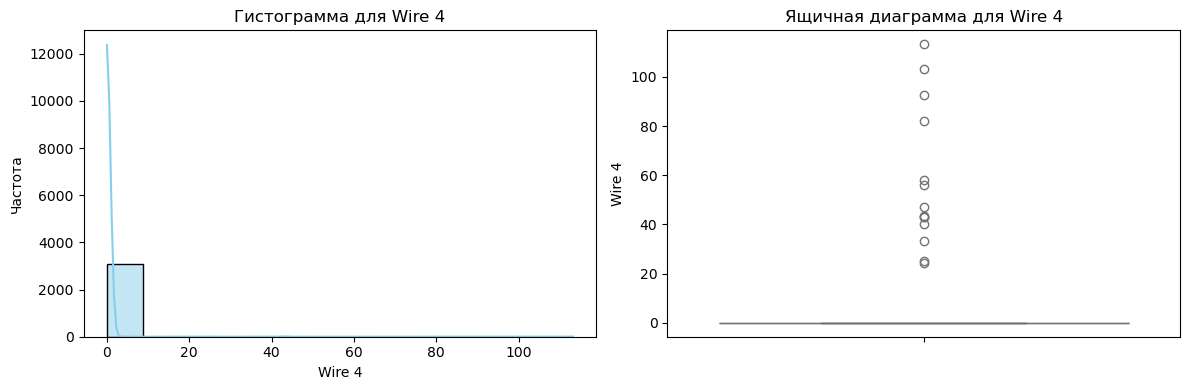

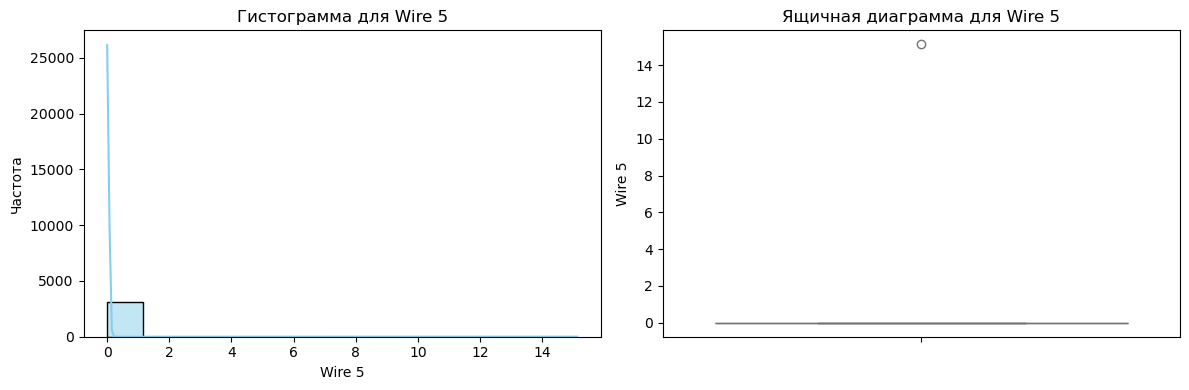

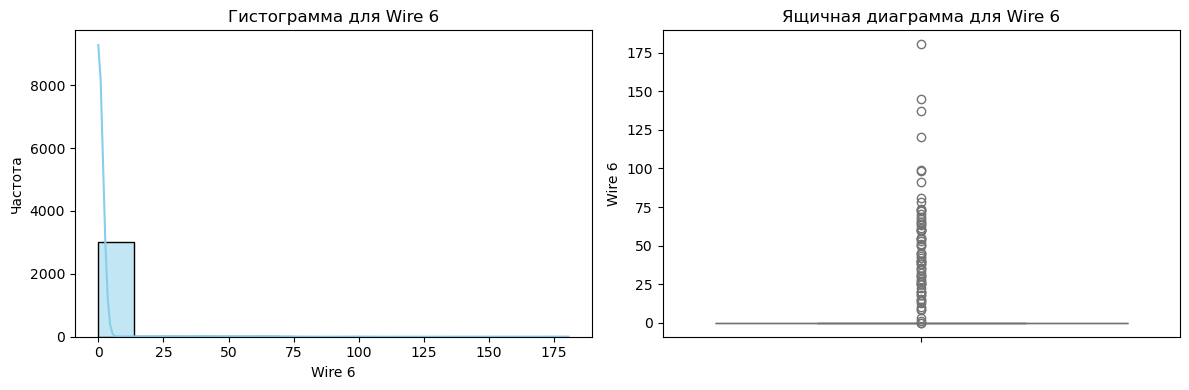

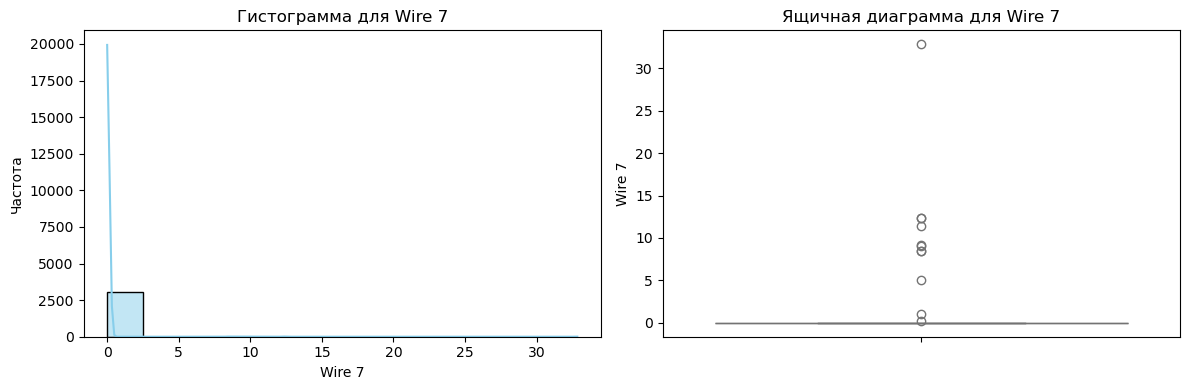

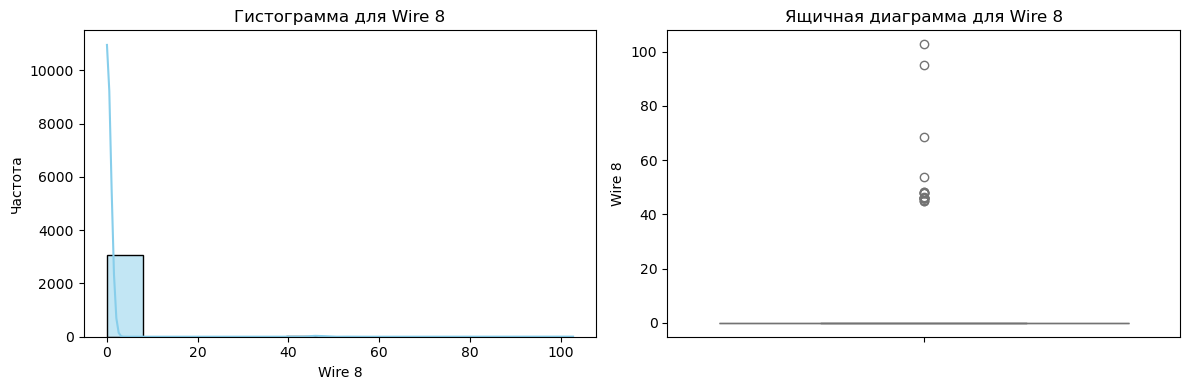

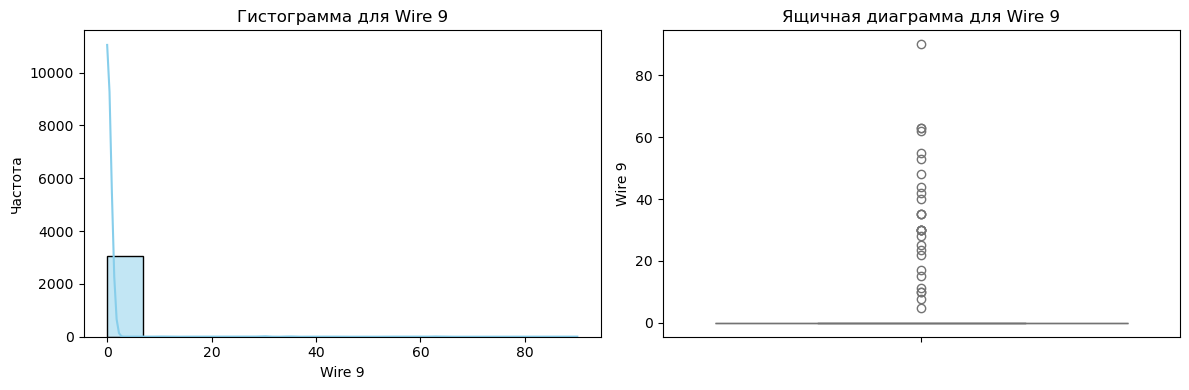

In [74]:
numerical_plot(data_wire_new.drop(columns=["key"]))

In [75]:
info_df(data_wire_time_new)

Первые строки датафрейма:


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

 
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

 
Основные статистики числовых данных:


count         mean         std  min    25%     50%     75%     max
key  3081.0  1623.426485  932.996726  1.0  823.0  1619.0  2434.0  3241.0

 
Количество дубликатов в датафрейме:
0
Количество пропусков в датафрейме:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


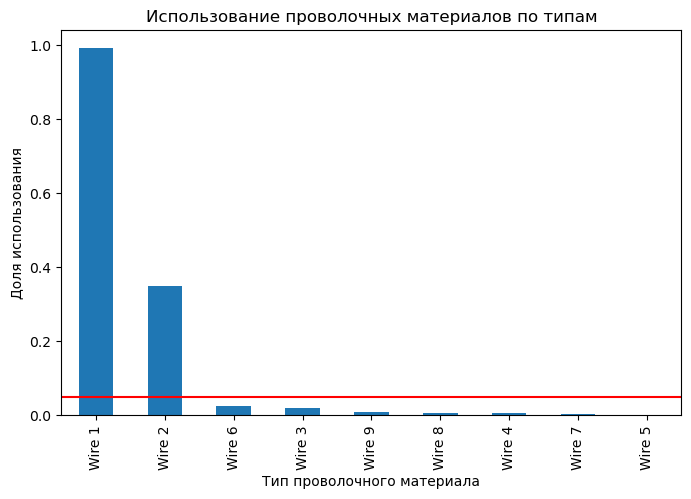

In [76]:
# Убираем столбец 'key', если он есть
data_without_key = data_wire_time_new.drop(columns=['key'], errors='ignore')

# Вычисляем долю использования каждого типа сыпучего материала
usage_ratio = (~data_without_key.isnull()).mean().sort_values(ascending=False)

# Строим столбчатую диаграмму
plt.figure(figsize=(8, 5))
ax = usage_ratio.plot(kind='bar')

# Добавляем горизонтальную линию для выделения 10% от общего количества записей
total_records = len(data_without_key)
threshold = 0.05  # 5% от общего числа
ax.axhline(y=threshold, color='r', linestyle='-')

# Заголовок и подписи для осей
ax.set_title('Использование проволочных материалов по типам')
ax.set_ylabel('Доля использования')
ax.set_xlabel('Тип проволочного материала')

# Отображаем график
plt.show()

Мы видим, что добавки wire 6, 3, 9, 8, 4, 7, 5 использовались менее чем в 5% случаев. Они могут быть излишними для модели, поэтому получим список (чтобы не опираться только на график) таких редких добавок, и объединим их в одну категорию — "Rare", чтобы уменьшить количество малозначимых признаков. Также добавим столбец с общим объемом всех добавок.

In [78]:
rare_additives = usage_ratio[usage_ratio < 0.05].index

# Выводим редкие добавки
print("Редкие проволочные добавки (использовались менее чем в 5% случаев):")
print(list(rare_additives))

# Добавляем столбцы 'Rare' и 'Total'
data_wire_new['Rare'] = data_wire_new[rare_additives].sum(axis=1)
data_wire_new = data_wire_new.drop(columns=rare_additives)
data_wire_new['Total'] = data_wire_new.drop(columns=['key', 'Rare'], errors='ignore').sum(axis=1)


Редкие проволочные добавки (использовались менее чем в 5% случаев):
['Wire 6', 'Wire 3', 'Wire 9', 'Wire 8', 'Wire 4', 'Wire 7', 'Wire 5']


Мы удаляем `data_wire_time_new`, так как она дублирует информацию и усложняет структуру данных. Вместо нее добавляем в `data_wire_new` два новых признака: `wire_addition_duration` (разница между первым и последним внесением) и `num_wire_types` (количество уникальных добавок). Это позволяет сохранить важную информацию о процессе без избыточных столбцов. Затем объединяем данные в `data_wire_combined` в результате данные становятся чище, компактнее и удобнее для анализа.

In [80]:
# Обрабатываем время добавок
data_wire_time_only = data_wire_time_new.drop(columns='key', errors='ignore').apply(pd.to_datetime, errors='coerce')
wire_time_stats = data_wire_time_new[['key']].copy()
wire_time_stats['wire_addition_duration'] = (data_wire_time_only.max(axis=1) - data_wire_time_only.min(axis=1)).dt.total_seconds()
wire_time_stats['num_wire_types'] = data_wire_time_only.notna().sum(axis=1)

# Объединяем данные
data_wire_combined = data_wire_new.merge(wire_time_stats, on='key', how='left')

# Выводим результат
display(data_wire_combined.head())

key     Wire 1   Wire 2  Rare      Total  wire_addition_duration  \
0    1  60.059998  0.00000   0.0  60.059998                     0.0   
1    2  96.052315  0.00000   0.0  96.052315                     0.0   
2    3  91.160157  0.00000   0.0  91.160157                     0.0   
3    4  89.063515  0.00000   0.0  89.063515                     0.0   
4    5  89.238236  9.11456   0.0  98.352796                   310.0   

   num_wire_types  
0               1  
1               1  
2               1  
3               1  
4               2

#### Промежуточный вывод по исследовательскому анализу и предобработке данных:

**1. data_arc_new:**  
Данный набор данных состоит из 14,876 записей и не содержит дубликатов и пропусков. Все столбцы с временем нагрева были преобразованы в формат datetime для удобства дальнейшей работы. В процессе подготовки данных были удалены выбросы, такие как отрицательные значения реактивной мощности. Также были добавлены новые признаки, такие как длительность нагрева и полная мощность. В результате была сформирована сводная таблица для агрегации данных по ковшам. Эти данные теперь полностью готовы для дальнейшего анализа.

**2. data_bulk_new:**  
В наборе данных с добавками содержится 3,129 уникальных записей. Пропуски в столбцах с добавками были заменены на нули. Добавки, которые использовались реже 5% случаев (например, bulk 5, 7, 2, 9, 13, 8), были объединены в категорию “Rare”. Дополнительно был добавлен столбец с общим объемом всех добавок, что улучшает восприятие данных. Также данные были объединены с набором `data_bulk_time_new`.

**3. data_gas_new:**  
Набор данных с газовыми показателями содержит 3,239 записей и не имеет дубликатов или пропусков. В данном случае выбросы газа (значения от 30 до 80) не были удалены, так как они могут быть значимыми для процесса. Данные остаются без изменений и готовы к использованию.

**4. data_temp_new:**  
В наборе данных о температуре содержится 18,092 записи, из которых 3,427 имеют пропуски. Температуры ниже 1400°C были исключены, так как они были признаны аномальными. Время замеров было преобразовано в формат datetime для улучшения точности. Также был добавлен индикатор “Итерация” для каждого ковша, что помогает отслеживать данные по отдельным процессам. Ковши с недостаточным количеством замеров были исключены, оставлены только те, у которых полные данные. В результате были получены финальные температуры и временные интервалы.

**5. data_wire_new:**  
Набор данных с проволочными материалами состоит из 3,081 записи, в которых присутствуют значительные пропуски для некоторых добавок (например, wire 3, 9, 8). Для добавок, использующихся реже 5% случаев, было принято решение либо исключить их, либо объединить в категорию “Rare”. Также были добавлены графики, которые визуализируют использование проволочных материалов. Данные были объединены с набором `data_wire_time_new`.

Общий итог:
- Все данные прошли очистку от дубликатов и пропусков, что сделало их более качественными для анализа.
- Были преобразованы и добавлены новые признаки для улучшения анализа.
- Аномальные значения, такие как отрицательные значения мощности и температуры ниже 1400°C, были удалены.
- Решение об объединении редких значений в категорию “Rare” позволит улучшить качество модели.
- На данный момент все данные готовы для построения модели и дальнейшего анализа.

### Объединение данных 

Объединим полученные датафреймы методом inner, чтобы в итоговой таблице остались только те ключи, которые присутствуют во всех датафреймах.

In [86]:
# Последовательное объединение таблиц
df_merged = data_arc_pivot.merge(data_bulk_combined, on='key', how='inner')
df_merged = df_merged.merge(data_gas_new, on='key', how='inner')
df_merged = df_merged.merge(data_wire_combined, on='key', how='inner')
df_merged = df_merged.merge(result_data, on='key', how='inner')

# Вывод первых строк результата
display(df_merged.head())

key  Активная мощность  Длительность (сек)  Полная мощность  \
0    1           3.036730              1098.0         3.718736   
1    2           2.139408               811.0         2.588349   
2    3           4.063641               655.0         5.019223   
3    4           2.706489               741.0         3.400038   
4    5           2.252950               869.0         2.816980   

   Реактивная мощность  Bulk 1  Bulk 3  Bulk 4  Bulk 6  Bulk 10  ...  \
0             2.142821     0.0     0.0    43.0     0.0      0.0  ...   
1             1.453357     0.0     0.0    73.0     0.0      0.0  ...   
2             2.937457     0.0     0.0    34.0     0.0      0.0  ...   
3             2.056992     0.0     0.0    81.0     0.0      0.0  ...   
4             1.687991     0.0     0.0    78.0     0.0      0.0  ...   

       Газ 1     Wire 1   Wire 2  Rare_y    Total_y  wire_addition_duration  \
0  29.749986  60.059998  0.00000     0.0  60.059998                     0.0   
1  12.555561  96.052315  0.00000     0.0  96.052315                     0.0   
2  28.554793  91.160157  0.00000     0.0  91.160157                     0.0   
3  18.841219  89.063515  0.00000     0.0  89.063515                     0.0   
4   5.413692  89.238236  9.11456     0.0  98.352796                   310.0   

   num_wire_types  Промежуток_между_замерами  Температура_на_старте  \
0               1                     1714.0                 1571.0   
1               1                     1265.0                 1581.0   
2               1                     1753.0                 1596.0   
3               1                     1220.0                 1601.0   
4               2                     1536.0                 1576.0   

   Финальная_температура  
0                 1613.0  
1                 1602.0  
2                 1599.0  
3                 1625.0  
4                 1602.0  

[5 rows x 28 columns]

In [87]:
df_merged

key  Активная мощность  Длительность (сек)  Полная мощность  \
0        1           3.036730              1098.0         3.718736   
1        2           2.139408               811.0         2.588349   
2        3           4.063641               655.0         5.019223   
3        4           2.706489               741.0         3.400038   
4        5           2.252950               869.0         2.816980   
...    ...                ...                 ...              ...   
2324  2495           3.168133               723.0         3.868721   
2325  2496           4.174918               940.0         5.070316   
2326  2497           3.605239               569.0         4.360918   
2327  2498           3.202310               750.0         3.909917   
2328  2499           1.737084               883.0         2.169252   

      Реактивная мощность  Bulk 1  Bulk 3  Bulk 4  Bulk 6  Bulk 10  ...  \
0                2.142821     0.0     0.0    43.0     0.0      0.0  ...   
1                1.453357     0.0     0.0    73.0     0.0      0.0  ...   
2                2.937457     0.0     0.0    34.0     0.0      0.0  ...   
3                2.056992     0.0     0.0    81.0     0.0      0.0  ...   
4                1.687991     0.0     0.0    78.0     0.0      0.0  ...   
...                   ...     ...     ...     ...     ...      ...  ...   
2324             2.210936     0.0    21.0     0.0     0.0     90.0  ...   
2325             2.872031     0.0     0.0    63.0     0.0    122.0  ...   
2326             2.452092     0.0     0.0    85.0     0.0      0.0  ...   
2327             2.239820     0.0    90.0     0.0     0.0    101.0  ...   
2328             1.296836     0.0    47.0     0.0     0.0      0.0  ...   

          Газ 1      Wire 1    Wire 2  Rare_y     Total_y  \
0     29.749986   60.059998   0.00000     0.0   60.059998   
1     12.555561   96.052315   0.00000     0.0   96.052315   
2     28.554793   91.160157   0.00000     0.0   91.160157   
3     18.841219   89.063515   0.00000     0.0   89.063515   
4      5.413692   89.238236   9.11456     0.0   98.352796   
...         ...         ...       ...     ...         ...   
2324   7.125735   89.150879   0.00000     0.0   89.150879   
2325   9.412616  114.179527   0.00000     0.0  114.179527   
2326   6.271699   94.086723   9.04800     0.0  103.134723   
2327  14.953657  118.110717   0.00000     0.0  118.110717   
2328  11.336151  110.160958  50.00528     0.0  160.166238   

      wire_addition_duration  num_wire_types  Промежуток_между_замерами  \
0                        0.0               1                     1714.0   
1                        0.0               1                     1265.0   
2                        0.0               1                     1753.0   
3                        0.0               1                     1220.0   
4                      310.0               2                     1536.0   
...                      ...             ...                        ...   
2324                     0.0               1                     1380.0   
2325                     0.0               1                     1705.0   
2326                   340.0               2                      962.0   
2327                     0.0               1                     1520.0   
2328                   390.0               2                     1537.0   

      Температура_на_старте  Финальная_температура  
0                    1571.0                 1613.0  
1                    1581.0                 1602.0  
2                    1596.0                 1599.0  
3                    1601.0                 1625.0  
4                    1576.0                 1602.0  
...                     ...                    ...  
2324                 1570.0                 1591.0  
2325                 1554.0                 1591.0  
2326                 1571.0                 1589.0  
2327                 1591.0                 1594.0  
2328                 1569.0                 1603

#### Промежуточный вывод по объединению данных
Объединение данных выполнено методом inner join, что позволило сохранить только те ключи, которые присутствуют во всех датафреймах. В результате получена финальная таблица с 28 признаками, включающая данные по мощности, температуре, расходу газа, проволоки и сыпучих материалов.

### Исследовательский анализ и предобработка данных объединённого датафрейма

Выведем названия столбцов, чтобы проверить, требуется ли их переименование:

In [92]:
for col in df_merged.columns:
    print(col)

key
Активная мощность
Длительность (сек)
Полная мощность
Реактивная мощность
Bulk 1
Bulk 3
Bulk 4
Bulk 6
Bulk 10
Bulk 11
Bulk 12
Bulk 14
Bulk 15
Rare_x
Total_x
bulk_addition_duration
num_bulk_types
Газ 1
Wire 1
Wire 2
Rare_y
Total_y
wire_addition_duration
num_wire_types
Промежуток_между_замерами
Температура_на_старте
Финальная_температура


Приведем названия столбцов к единому стилю:

In [94]:
rename_dict = {
    "key": "key",
    "Активная мощность": "active_power",
    "Реактивная мощность": "reactive_power",
    "Длительность (сек)": "heat_duration_sec",
    "Полная мощность": "total_power",
    "Bulk 1": "bulk_1",
    "Bulk 3": "bulk_3",
    "Bulk 4": "bulk_4",
    "Bulk 6": "bulk_6",
    "Bulk 10": "bulk_10",
    "Bulk 11": "bulk_11",
    "Bulk 12": "bulk_12",
    "Bulk 14": "bulk_14",
    "Bulk 15": "bulk_15",
    "Rare_x": "rare_bulk",
    "Total_x": "total_bulk",
    "bulk_addition_duration": "bulk_addition_duration",
    "num_bulk_types": "num_bulk_types",
    "Газ 1": "gas_1",
    "Wire 1": "wire_1",
    "Wire 2": "wire_2",
    "Rare_y": "rare_wire",
    "Total_y": "total_wire",
    "wire_addition_duration": "wire_addition_duration",
    "num_wire_types": "num_wire_types",
    "Промежуток_между_замерами": "time_between_measurements",
    "Температура_на_старте": "start_temperature",
    "Финальная_температура": "final_temperature",
}

In [95]:
# Переименовываем столбцы
df_merged = df_merged.rename(columns=rename_dict)
df_merged.head()

key  active_power  heat_duration_sec  total_power  reactive_power  bulk_1  \
0    1      3.036730             1098.0     3.718736        2.142821     0.0   
1    2      2.139408              811.0     2.588349        1.453357     0.0   
2    3      4.063641              655.0     5.019223        2.937457     0.0   
3    4      2.706489              741.0     3.400038        2.056992     0.0   
4    5      2.252950              869.0     2.816980        1.687991     0.0   

   bulk_3  bulk_4  bulk_6  bulk_10  ...      gas_1     wire_1   wire_2  \
0     0.0    43.0     0.0      0.0  ...  29.749986  60.059998  0.00000   
1     0.0    73.0     0.0      0.0  ...  12.555561  96.052315  0.00000   
2     0.0    34.0     0.0      0.0  ...  28.554793  91.160157  0.00000   
3     0.0    81.0     0.0      0.0  ...  18.841219  89.063515  0.00000   
4     0.0    78.0     0.0      0.0  ...   5.413692  89.238236  9.11456   

   rare_wire  total_wire  wire_addition_duration  num_wire_types  \
0        0.0   60.059998                     0.0               1   
1        0.0   96.052315                     0.0               1   
2        0.0   91.160157                     0.0               1   
3        0.0   89.063515                     0.0               1   
4        0.0   98.352796                   310.0               2   

   time_between_measurements  start_temperature  final_temperature  
0                     1714.0             1571.0             1613.0  
1                     1265.0             1581.0             1602.0  
2                     1753.0             1596.0             1599.0  
3                     1220.0             1601.0             1625.0  
4                     1536.0             1576.0             1602.0  

[5 rows x 28 columns]

Создадим новые признаки физических характеристик:
-    Отношение активной к полной мощности (насколько эффективно используется энергия)
-    Количество уникальных добавок (bulk + wire)

In [98]:
df_merged["active_to_total_power"] = df_merged["active_power"] / df_merged["total_power"]
df_merged["total_material_types"] = df_merged["num_bulk_types"] + df_merged["num_wire_types"]

Построим матрицу корреляции PHIK для числовых признаков, чтобы выявить взаимосвязи между переменными. Это поможет определить признаки с высокой корреляцией, которые могут быть избыточными и негативно повлиять на работу модели.

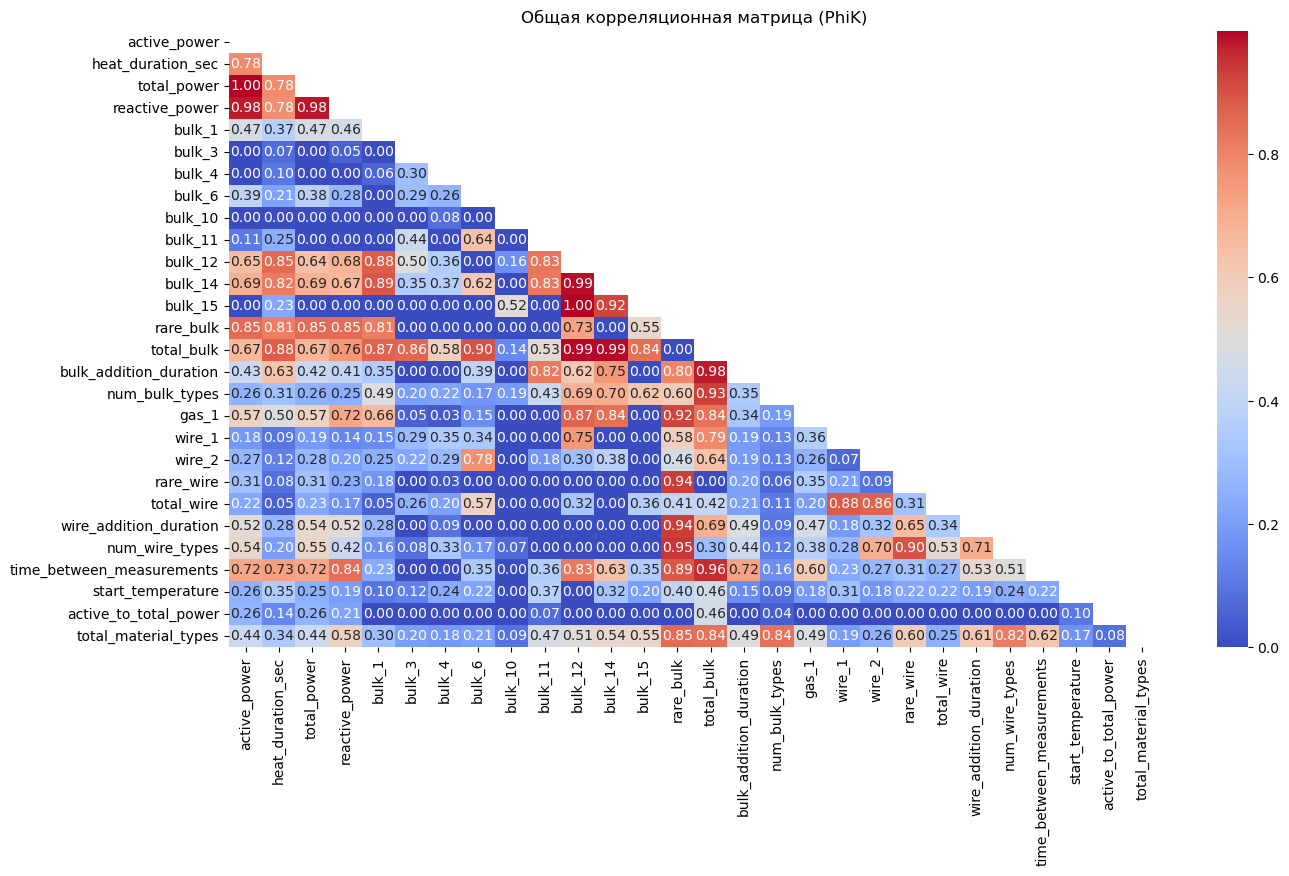

In [101]:
interval_cols = [
    'active_power', 'reactive_power', 'total_power', 'active_to_total_power',
    'heat_duration_sec', 'time_between_measurements', 'wire_addition_duration', 'bulk_addition_duration',
    'start_temperature', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_10',
    'total_wire', 'rare_wire', 'gas_1', 'wire_1', 'wire_2'
]
target_col = 'final_temperature'

# Удаляем 'key' перед расчетом корреляции
df_corr = df_merged.drop(columns=['key','final_temperature'])

# Общая корреляционная матрица для всего датасета
phik_corr_matrix = df_corr.phik_matrix(interval_cols=interval_cols)

# Маска для верхнего треугольника
mask = np.triu(np.ones_like(phik_corr_matrix, dtype=bool))

# Визуализация общей корреляционной матрицы
plt.figure(figsize=(15, 8))
sns.heatmap(phik_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Общая корреляционная матрица (PhiK)")
plt.show()

Выведем пары признаков с корреляцией выше 0.9. Такие признаки избыточны, поэтому перед подачей в модель мы выберем, какие из них удалить.

In [103]:
# Фильтруем пары с корреляцией выше 0.9
high_corr_pairs = phik_corr_matrix[phik_corr_matrix > 0.9].stack()

# Оставляем только уникальные пары (без дублирования одинаковых сочетаний)
high_corr_pairs = high_corr_pairs[high_corr_pairs.index.get_level_values(0) != high_corr_pairs.index.get_level_values(1)]

# Выводим результат
display(high_corr_pairs)

active_power               total_power                  0.999816
                           reactive_power               0.977717
total_power                active_power                 0.999816
                           reactive_power               0.984122
reactive_power             active_power                 0.977717
                           total_power                  0.984122
bulk_6                     total_bulk                   0.901892
bulk_12                    bulk_14                      0.990934
                           bulk_15                      0.996957
                           total_bulk                   0.994204
bulk_14                    bulk_12                      0.990934
                           bulk_15                      0.923819
                           total_bulk                   0.992637
bulk_15                    bulk_12                      0.996957
                           bulk_14                      0.923819
rare_bulk                

**Удаление ненужных признаков**


При удалении признаков мы учитываем:  
1. **Высокую корреляцию (0.9+):** признаки дублируют друг друга, можно оставить один.  
2. **Зависимость с `final_temperature`:** оставляем те, что имеют смысловую связь с температурой.  

---

Пройдемся по признакам, с корреляцией выше 0.9:
1. Мощность  
- `reactive_power` (сильно коррелирует с `active_power` и `total_power`)  
- `active_power` (почти 1 с `total_power`)  
✅ **Оставляем `total_power`**, так как он обобщает активную и реактивную мощности.  

2. Сыпучие материалы (`bulk_*`)  
- `bulk_12`, `bulk_14`, `bulk_15` коррелируют между собой и с `total_bulk`.  
- `bulk_6` (корреляция 0.90 с `total_bulk`).  
✅ **Оставляем `total_bulk`**, он обобщает объёмы.  

3. Редкие добавки (`rare_bulk`, `rare_wire`)  
- `rare_bulk` сильно связан с `gas_1`, `rare_wire`, `num_wire_types`, `final_temperature`.  
- `rare_wire` дублирует `rare_bulk`.  
✅ **Оставляем `rare_bulk` или `num_wire_types`**.  

4. Признаки времени  
- `time_between_measurements` ≈ `total_bulk` (0.96).  
- `bulk_addition_duration` ≈ `total_bulk` (0.97).  
- `wire_addition_duration` связан с `rare_bulk`, `num_wire_types` (>0.93).  
✅ **Удаляем `time_between_measurements`, оставляем `bulk_addition_duration` и `wire_addition_duration`**.  

---

**Финальный список**
- ❌ `reactive_power`, `active_power`, `bulk_6`, `bulk_12`, `bulk_14`, `bulk_15`, `rare_wire`, `time_between_measurements`.  
- ✔ `total_power`, `total_bulk`, `rare_bulk` (или `num_wire_types`), `bulk_addition_duration`, `wire_addition_duration`.  


In [106]:
columns_to_drop = [
    'reactive_power', 'active_power',
    'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15',
    'rare_wire',
    'time_between_measurements'
]

# Удаляем столбцы
df_merged = df_merged.drop(columns=columns_to_drop, errors='ignore')

# Проверяем результат
df_merged.head()


key  heat_duration_sec  total_power  bulk_1  bulk_3  bulk_4  bulk_10  \
0    1             1098.0     3.718736     0.0     0.0    43.0      0.0   
1    2              811.0     2.588349     0.0     0.0    73.0      0.0   
2    3              655.0     5.019223     0.0     0.0    34.0      0.0   
3    4              741.0     3.400038     0.0     0.0    81.0      0.0   
4    5              869.0     2.816980     0.0     0.0    78.0      0.0   

   bulk_11  rare_bulk  total_bulk  ...      gas_1     wire_1   wire_2  \
0      0.0        0.0       553.0  ...  29.749986  60.059998  0.00000   
1      0.0        0.0       582.0  ...  12.555561  96.052315  0.00000   
2      0.0        0.0       544.0  ...  28.554793  91.160157  0.00000   
3      0.0        0.0       595.0  ...  18.841219  89.063515  0.00000   
4      0.0        0.0       584.0  ...   5.413692  89.238236  9.11456   

   total_wire  wire_addition_duration  num_wire_types  start_temperature  \
0   60.059998                     0.0               1             1571.0   
1   96.052315                     0.0               1             1581.0   
2   91.160157                     0.0               1             1596.0   
3   89.063515                     0.0               1             1601.0   
4   98.352796                   310.0               2             1576.0   

   final_temperature  active_to_total_power  total_material_types  
0             1613.0               0.816603                     5  
1             1602.0               0.826553                     5  
2             1599.0               0.809615                     5  
3             1625.0               0.796017                     5  
4             1602.0               0.799775                     6  

[5 rows x 22 columns]

Построим гарфики scatterplot для целевого признака:

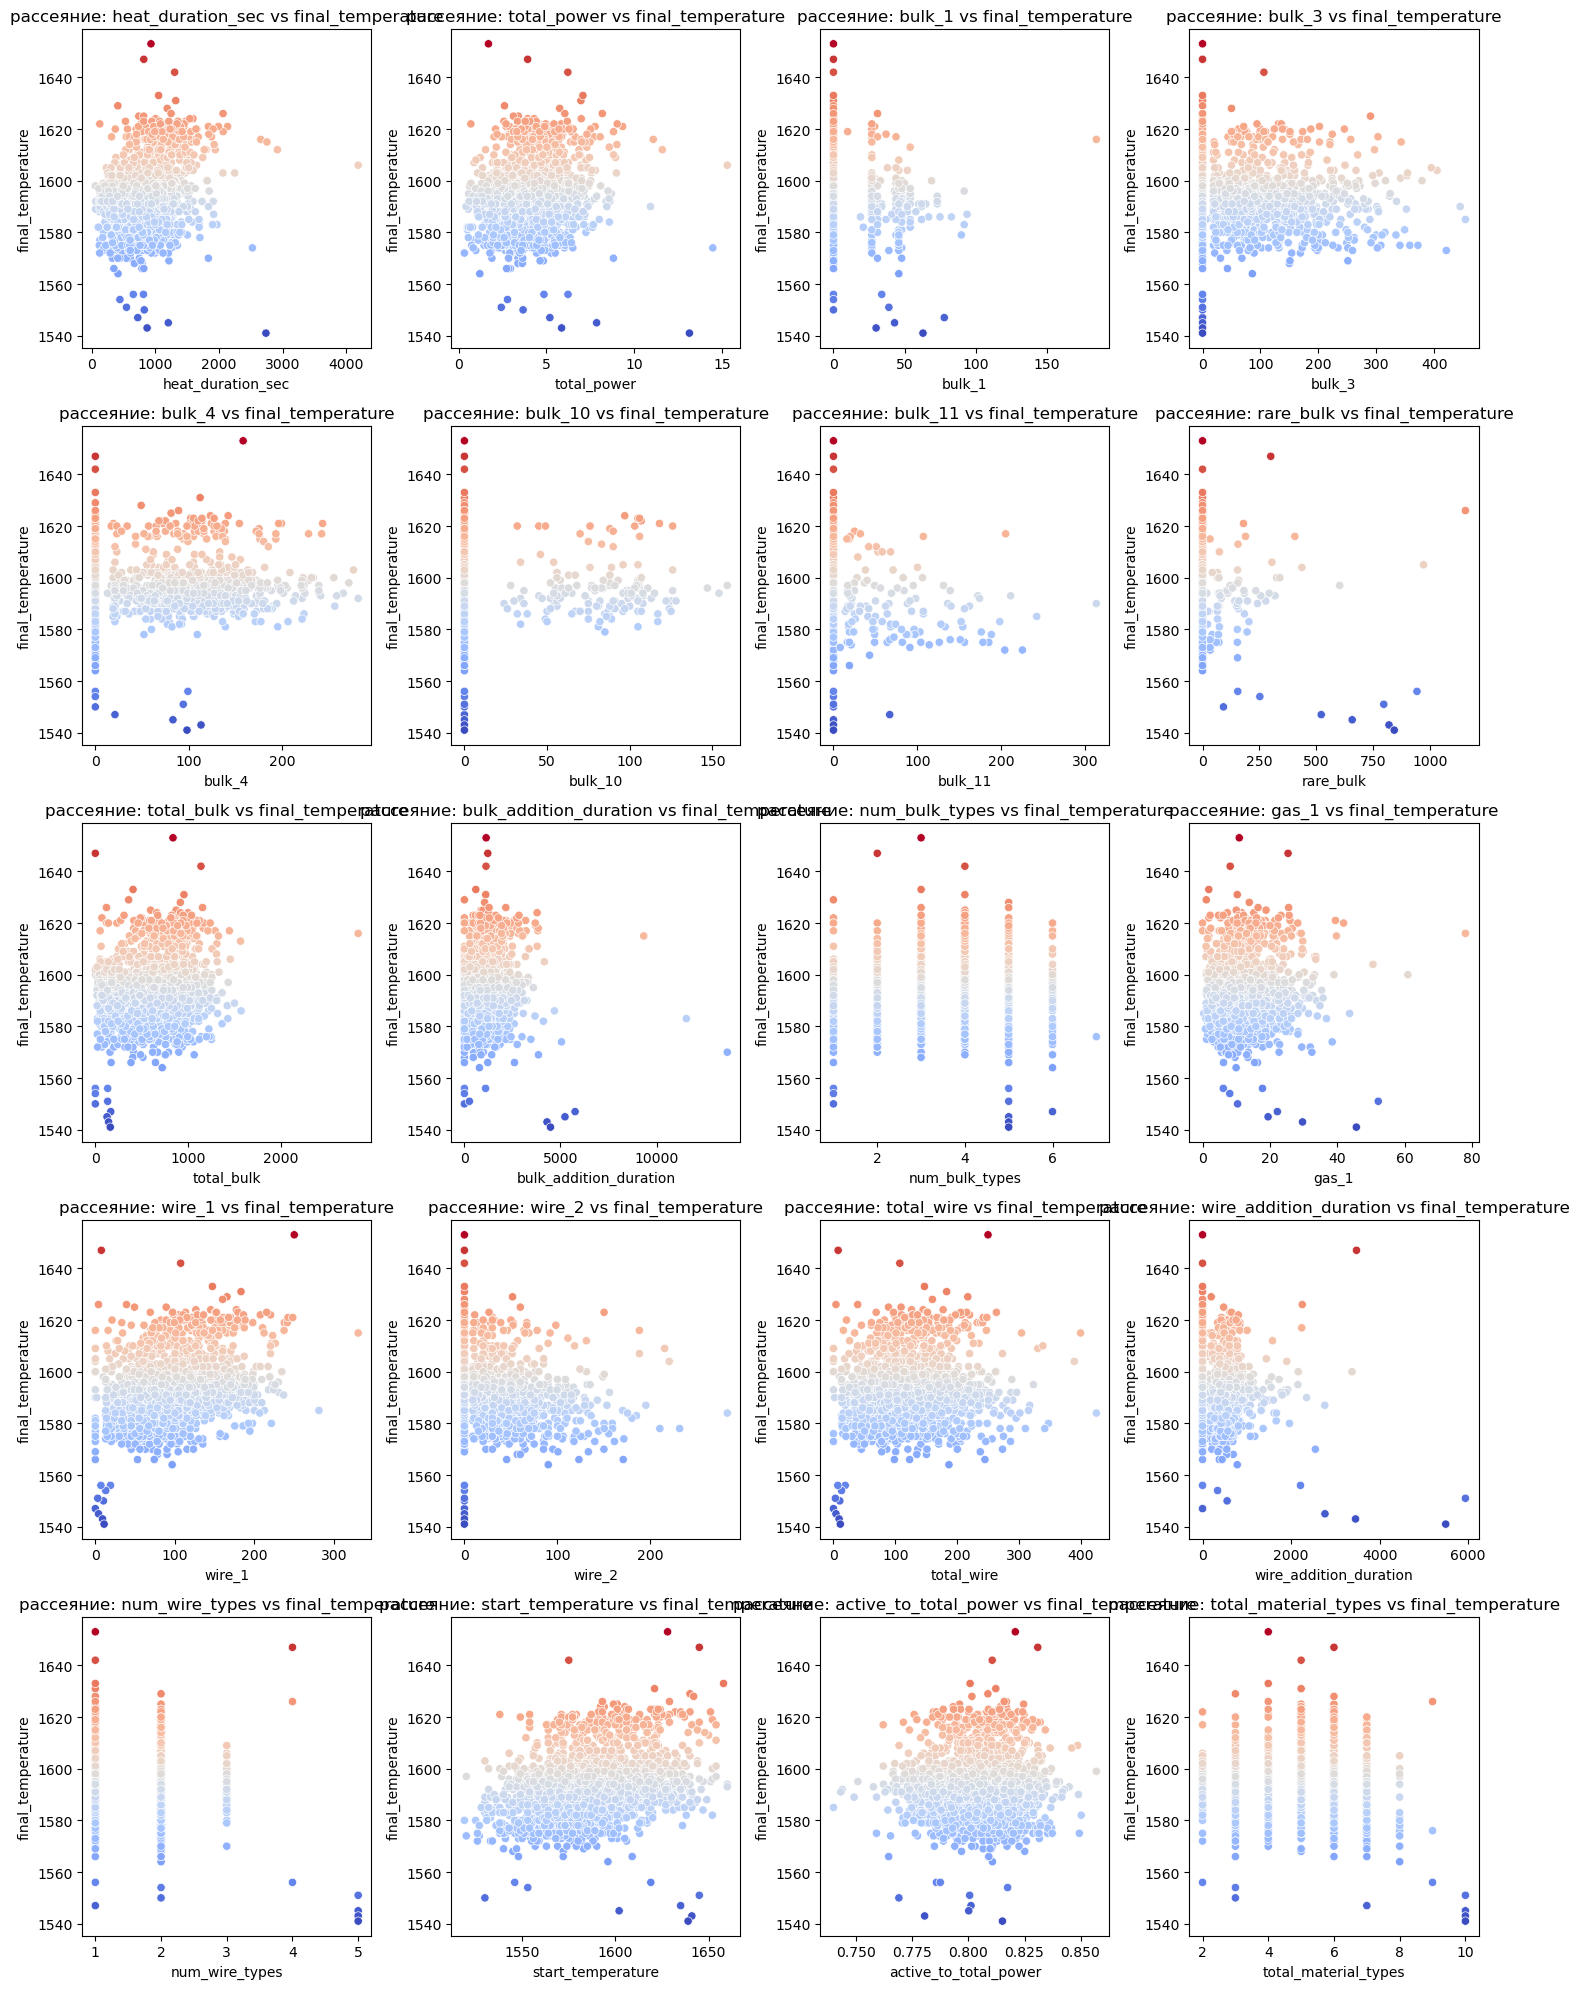

In [108]:
# Выбираем все числовые столбцы (включая целевой)
numerical_cols = df_merged.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Убираем целевой столбец из списка признаков для построения графиков
numerical_cols.remove(target_col)
numerical_cols.remove('key')

# Рассчитываем количество строк и столбцов для подграфиков
n_cols = 4  # Максимальное количество столбцов
n_rows = math.ceil(len(numerical_cols) / n_cols)  # Количество строк для размещения всех графиков

# Построение скаттерплотов для всех числовых признаков против целевой переменной
plt.figure(figsize=(15, 4 * n_rows))

for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)  # Подбор размера сетки (динамически)
    # Используем цветовую градацию по целевому столбцу
    sns.scatterplot(x=df_merged[col], y=df_merged[target_col], hue=df_merged[target_col], palette="coolwarm", legend=None)
    plt.title(f"рассеяние: {col} vs {target_col}")
    plt.xlabel(col)
    plt.ylabel(target_col)

plt.tight_layout()
plt.show()

*Анализ scatter plot (финальная температура vs признаки)*:


1. Мощность и нагрев  
- Чем больше **total_power** и **heat_duration_sec**, тем выше температура, но зависимость не линейная.  
- **active_to_total_power** особо не влияет, хотя есть слабая положительная тенденция.  

2. Добавки (bulk и wire)  
- **bulk_1, rare_bulk** чаще снижают температуру.  
- **bulk_3, bulk_10, bulk_11** вроде бы повышают, но данных слишком много, разброс сильный.  
- **total_bulk** увеличивает разброс температур, но не даёт очевидной зависимости.  
- **wire_1, wire_2, total_wire** – чем больше проволоки, тем выше температура, но эффект заметен только до определённого предела.  
- **wire_addition_duration** – чем дольше добавляют проволоку, тем ниже температура (логично, охлаждает).  

3. Газ  
- **gas_1** вероятно охлаждает – чем больше, тем ниже температура.  

4. Стартовая температура  
- Ожидаемо: чем выше **start_temperature**, тем выше итоговая.  

5. Разные типы материалов  
- **num_bulk_types, num_wire_types, total_material_types** не показывают явной зависимости, но могут влиять на вариативность температуры.  

Важные наблюдения:
- **start_temperature** – самая логичная и сильная связь.  
- **total_power, heat_duration_sec** – важны, но есть разброс.  
- **total_wire, wire_1, wire_2** – проволока повышает температуру, но эффект ослабевает.  
- **gas_1, wire_addition_duration** – охлаждают.  

Менее значимые:
- Количество типов bulk/wire  
- Отдельные bulk-добавки без чёткой связи  


In [112]:
info_df(df_merged)

Первые строки датафрейма:


key  heat_duration_sec  total_power  bulk_1  bulk_3  bulk_4  bulk_10  \
0    1             1098.0     3.718736     0.0     0.0    43.0      0.0   
1    2              811.0     2.588349     0.0     0.0    73.0      0.0   
2    3              655.0     5.019223     0.0     0.0    34.0      0.0   
3    4              741.0     3.400038     0.0     0.0    81.0      0.0   
4    5              869.0     2.816980     0.0     0.0    78.0      0.0   

   bulk_11  rare_bulk  total_bulk  ...      gas_1     wire_1   wire_2  \
0      0.0        0.0       553.0  ...  29.749986  60.059998  0.00000   
1      0.0        0.0       582.0  ...  12.555561  96.052315  0.00000   
2      0.0        0.0       544.0  ...  28.554793  91.160157  0.00000   
3      0.0        0.0       595.0  ...  18.841219  89.063515  0.00000   
4      0.0        0.0       584.0  ...   5.413692  89.238236  9.11456   

   total_wire  wire_addition_duration  num_wire_types  start_temperature  \
0   60.059998                     0.0               1             1571.0   
1   96.052315                     0.0               1             1581.0   
2   91.160157                     0.0               1             1596.0   
3   89.063515                     0.0               1             1601.0   
4   98.352796                   310.0               2             1576.0   

   final_temperature  active_to_total_power  total_material_types  
0             1613.0               0.816603                     5  
1             1602.0               0.826553                     5  
2             1599.0               0.809615                     5  
3             1625.0               0.796017                     5  
4             1602.0               0.799775                     6  

[5 rows x 22 columns]

 
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     2329 non-null   int64  
 1   heat_duration_sec       2329 non-null   float64
 2   total_power             2329 non-null   float64
 3   bulk_1                  2329 non-null   float64
 4   bulk_3                  2329 non-null   float64
 5   bulk_4                  2329 non-null   float64
 6   bulk_10                 2329 non-null   float64
 7   bulk_11                 2329 non-null   float64
 8   rare_bulk               2329 non-null   float64
 9   total_bulk              2329 non-null   float64
 10  bulk_addition_duration  2329 non-null   float64
 11  num_bulk_types          2329 non-null   int64  
 12  gas_1                   2329 non-null   float64
 13  wire_1                  2329 non-null   float64
 14  wire_2       

None

 
Основные статистики числовых данных:


count         mean         std          min  \
key                     2329.0  1251.832546  714.762400     1.000000   
heat_duration_sec       2329.0   807.600687  340.897332    57.000000   
total_power             2329.0     3.884654    1.518157     0.331897   
bulk_1                  2329.0     3.427651   12.412132     0.000000   
bulk_3                  2329.0    47.348218   75.310430     0.000000   
bulk_4                  2329.0    37.303564   58.643238     0.000000   
bulk_10                 2329.0     5.052812   20.917800     0.000000   
bulk_11                 2329.0     4.245170   22.515487     0.000000   
rare_bulk               2329.0     7.600687   59.461243     0.000000   
total_bulk              2329.0   602.029626  287.411716     0.000000   
bulk_addition_duration  2329.0   985.905968  815.668796     0.000000   
num_bulk_types          2329.0     3.592958    1.224416     1.000000   
gas_1                   2329.0    11.375600    6.392041     0.008399   
wire_1                  2329.0   102.443601   43.539993     0.000000   
wire_2                  2329.0    17.609859   33.624771     0.000000   
total_wire              2329.0   120.053460   53.163603     0.000000   
wire_addition_duration  2329.0   209.708459  390.096311     0.000000   
num_wire_types          2329.0     1.397166    0.564416     1.000000   
start_temperature       2329.0  1587.386003   23.619841  1519.000000   
final_temperature       2329.0  1593.365393   11.200915  1541.000000   
active_to_total_power   2329.0     0.804714    0.014697     0.739769   
total_material_types    2329.0     4.990125    1.305022     2.000000   

                                25%          50%          75%           max  
key                      630.000000  1255.000000  1868.000000   2499.000000  
heat_duration_sec        581.000000   778.000000   993.000000   4189.000000  
total_power                2.843058     3.767499     4.769421     15.288271  
bulk_1                     0.000000     0.000000     0.000000    185.000000  
bulk_3                     0.000000     0.000000    80.000000    454.000000  
bulk_4                     0.000000     0.000000    77.000000    281.000000  
bulk_10                    0.000000     0.000000     0.000000    159.000000  
bulk_11                    0.000000     0.000000     0.000000    313.000000  
rare_bulk                  0.000000     0.000000     0.000000   1156.000000  
total_bulk               429.000000   605.000000   791.000000   2829.000000  
bulk_addition_duration   501.000000   894.000000  1340.000000  13683.000000  
num_bulk_types             3.000000     4.000000     4.000000      7.000000  
gas_1                      7.282948    10.100950    14.216688     77.995040  
wire_1                    73.207679   101.119201   128.091599    330.314424  
wire_2                     0.000000     0.000000    23.102560    282.780152  
total_wire                87.287199   115.081200   150.181198    425.145752  
wire_addition_duration     0.000000     0.000000   396.000000   5937.000000  
num_wire_types             1.000000     1.000000     2.000000      5.000000  
start_temperature       1571.000000  1587.000000  1603.000000   1660.000000  
final_temperature       1587.000000  1593.000000  1598.000000   1653.000000  
active_to_total_power      0.795215     0.805671     0.814625      0.857042  
total_material_types       4.000000     5.000000     6.000000     10.000000

 
Количество дубликатов в датафрейме:
0
Количество пропусков в датафрейме:
key                       0
heat_duration_sec         0
total_power               0
bulk_1                    0
bulk_3                    0
bulk_4                    0
bulk_10                   0
bulk_11                   0
rare_bulk                 0
total_bulk                0
bulk_addition_duration    0
num_bulk_types            0
gas_1                     0
wire_1                    0
wire_2                    0
total_wire                0
wire_addition_duration    0
num_wire_types            0
start_temperature         0
final_temperature         0
active_to_total_power     0
total_material_types      0
dtype: int64


**Анализ данных (df_merged)**

📊 Общая информация
- **Размер**: `2329 строк × 22 столбца`
- **Пропусков**: ❌ **нет**
- **Дубликатов**: ❌ **нет**
- **Типы данных**: `float64` (18), `int64` (4)

🔥 Ключевые наблюдения  

✅ Энергопотребление и время
- **Средняя длительность нагрева**: `807.6 сек` _(от 57 до 4189 сек)_
- **total_power** варьируется от **0.33 до 15.3**, среднее — **3.88**
- **Стабильный коэффициент** `active_to_total_power`: **0.80 ± 0.01**, что может указывать на закономерности в энергопотреблении.

✅ Сыпучие материалы (`bulk_*`)
- **total_bulk**: `602.0 ± 287.4` _(от 0 до 2829)_
- `bulk_1`, `bulk_3`, `bulk_4`, `bulk_10`, `bulk_11` часто **нулевые**, но могут достигать **185–454** единиц.
- **rare_bulk**: среднее значение **7.6**, но в отдельных случаях может достигать **1156**.

✅ Газ и проволока
- **total_wire**: среднее **120.1**, максимальное **425.1**
- **wire_2** часто **отсутствует**, в отличие от `wire_1`.
- **wire_addition_duration** сильно варьируется от **0 до 5937 сек**, что указывает на разные сценарии подачи проволоки.
- **gas_1**: в основном **10–14**, но в отдельных случаях может достигать **77.9**.

✅ Температура
- **start_temperature**: `1587.4 ± 23.6` _(от 1519 до 1660)_
- **final_temperature**: `1593.4 ± 11.2` _(от 1541 до 1653)_
- **Разброс температуры небольшой**, что может упростить прогнозирование.

---

📝 Выводы
- **Пропусков и дубликатов нет**, можно сразу приступать к анализу.
- Некоторые признаки (`bulk_*`, `wire_2`, `rare_bulk`) имеют **много нулевых значений**, стоит проверить их значимость.
- Временные параметры (`heat_duration_sec`, `wire_addition_duration`, `bulk_addition_duration`) **очень варьируются**, возможно, стоит их нормализовать.
- Температура изменяется **незначительно**, но имеет логичные границы, что упрощает моделирование.

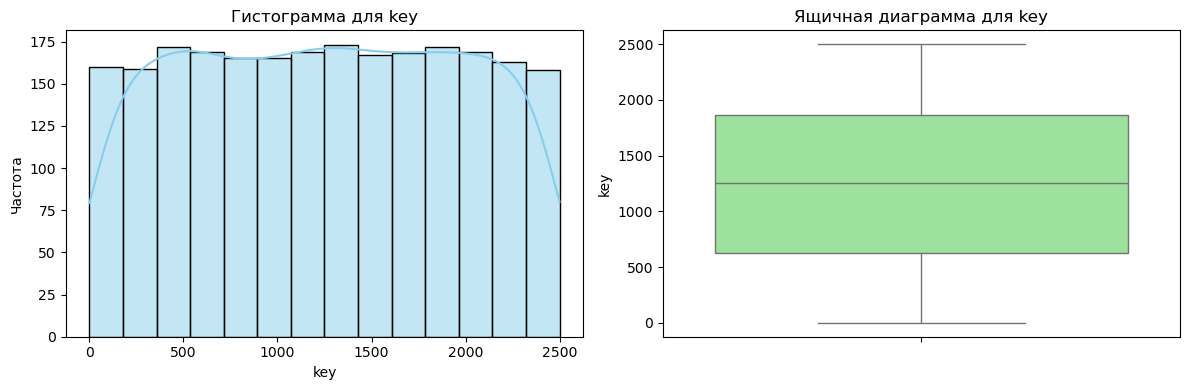

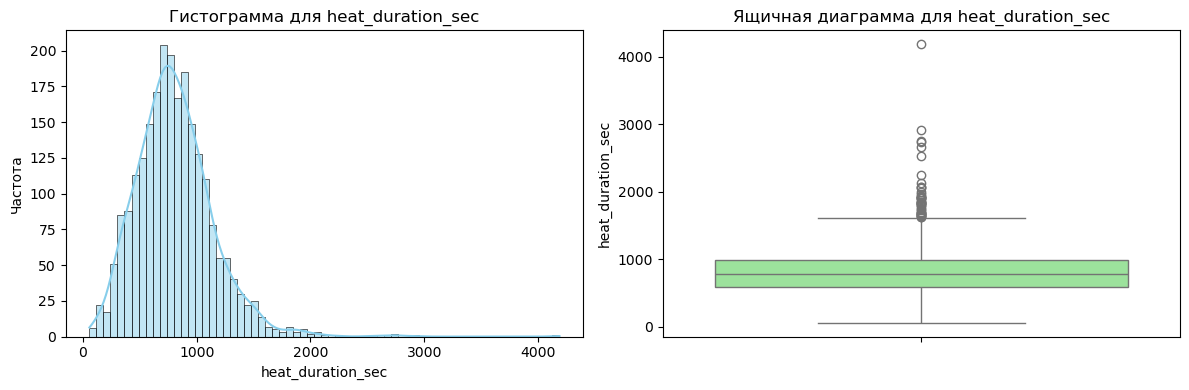

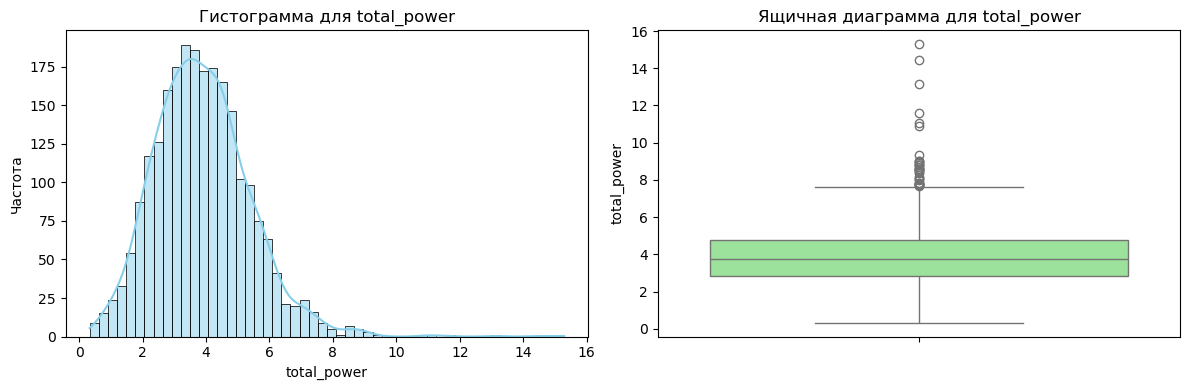

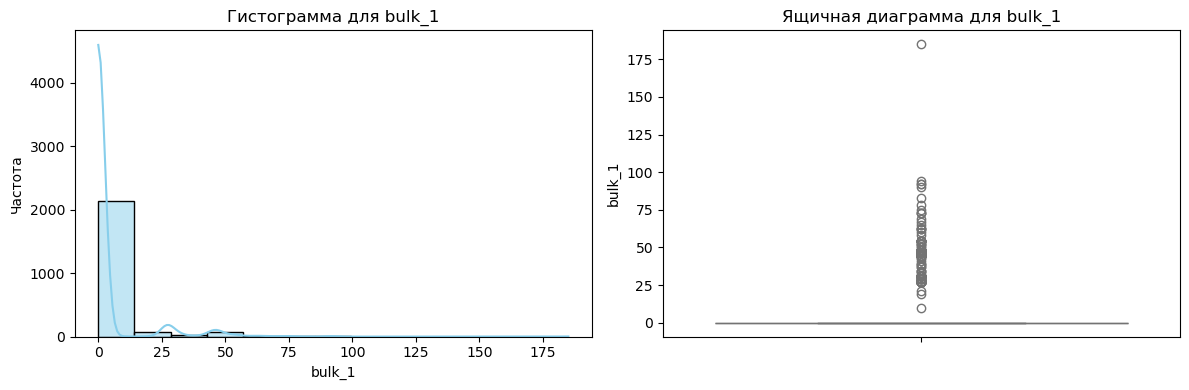

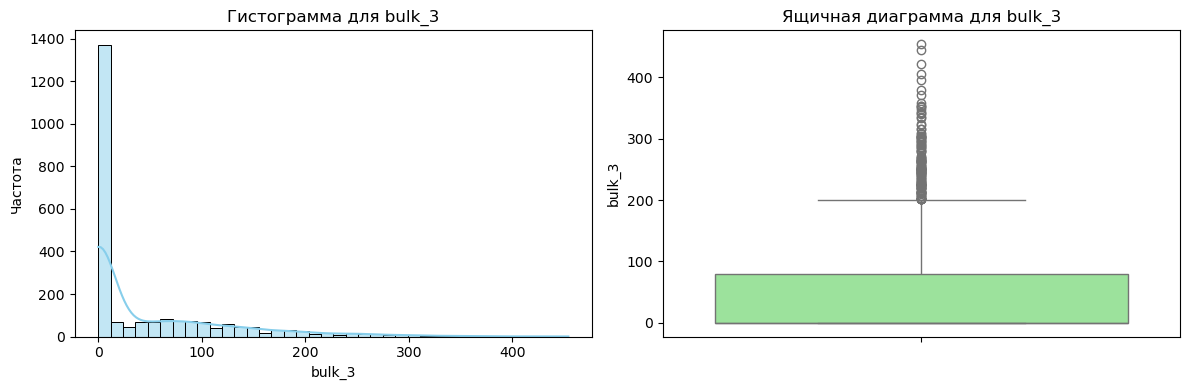

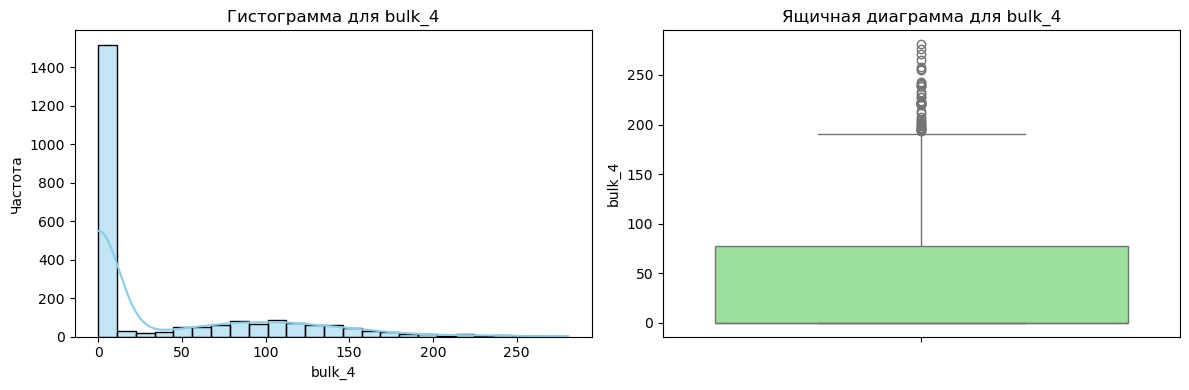

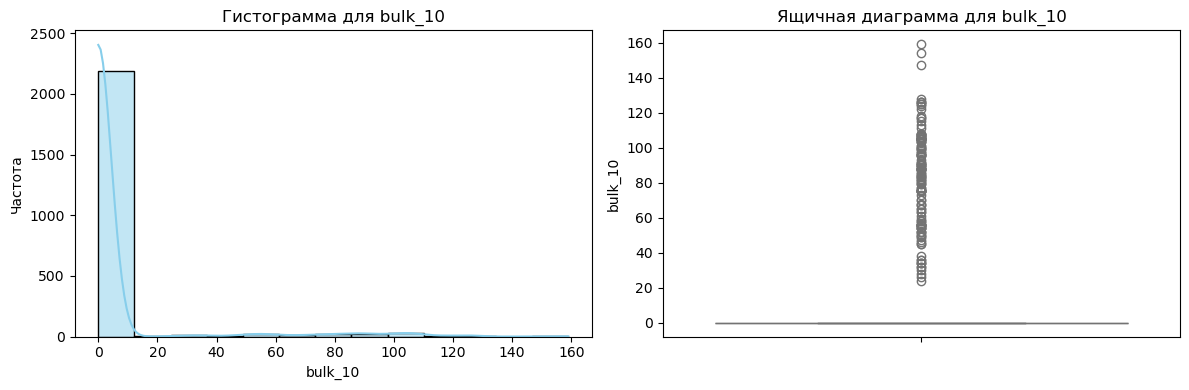

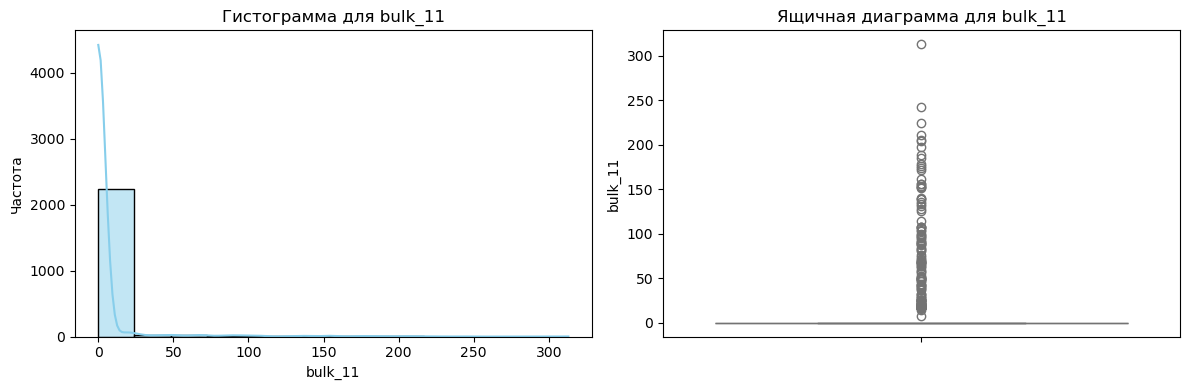

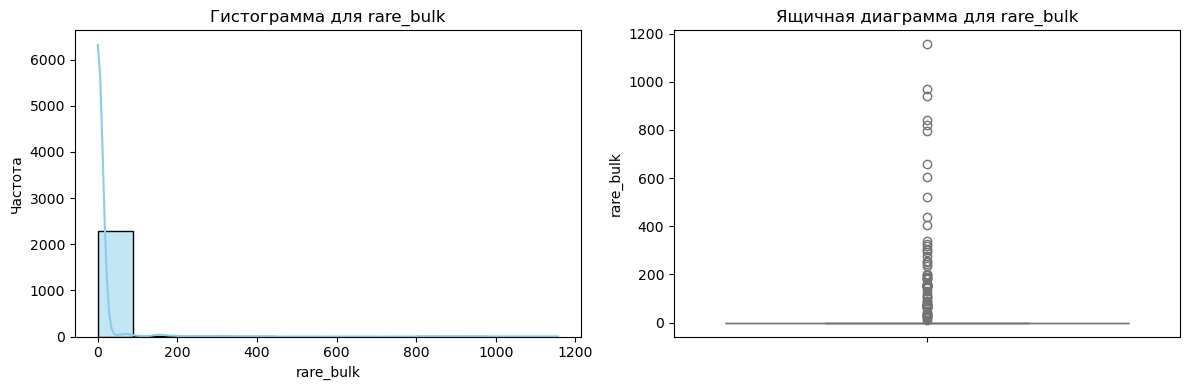

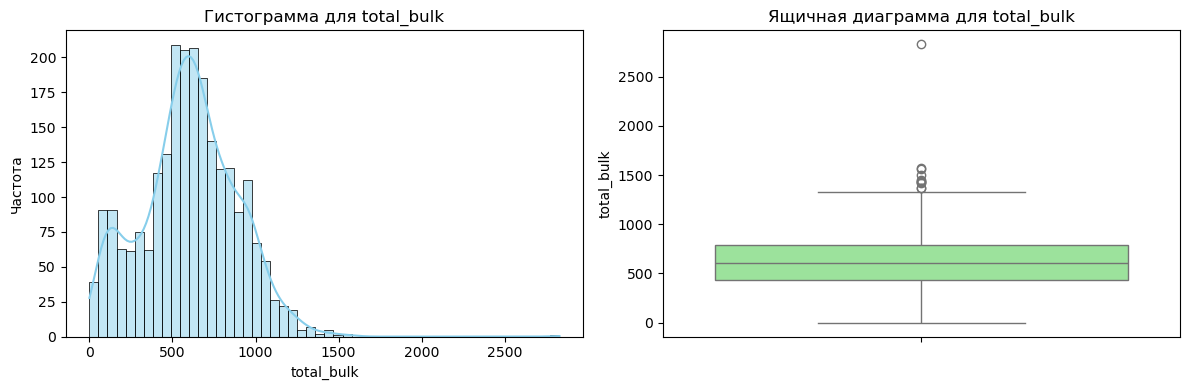

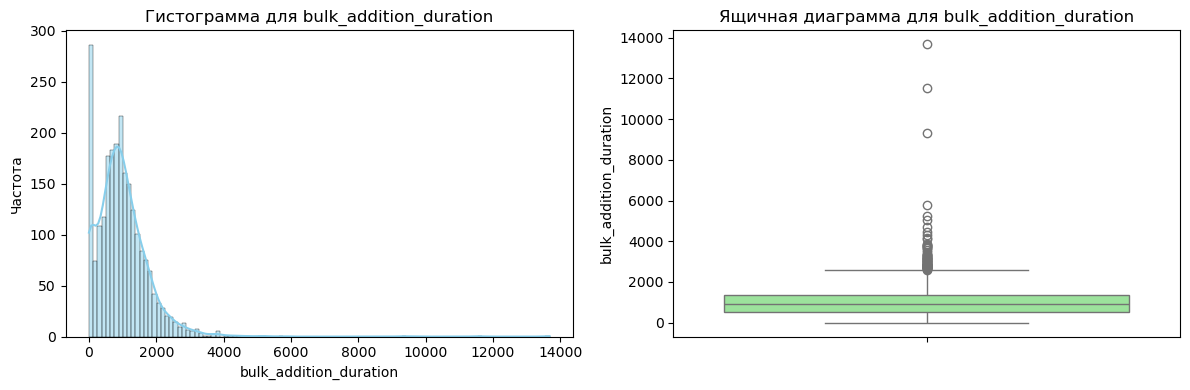

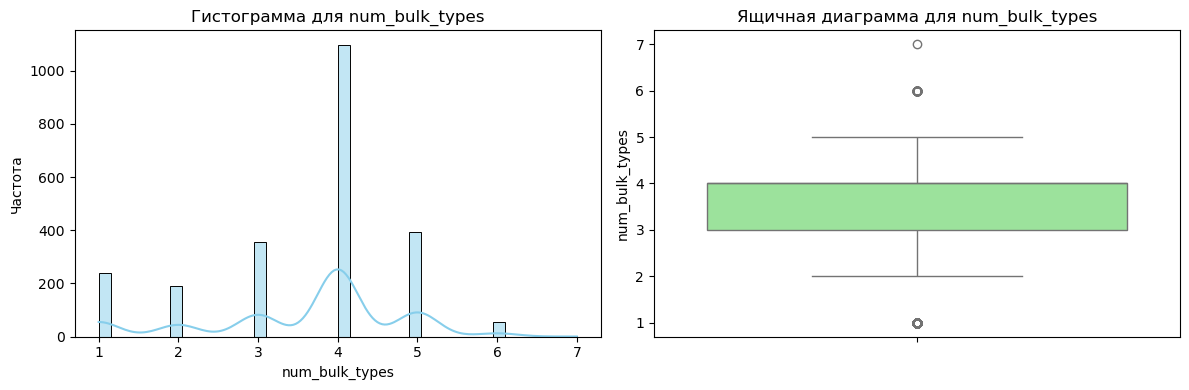

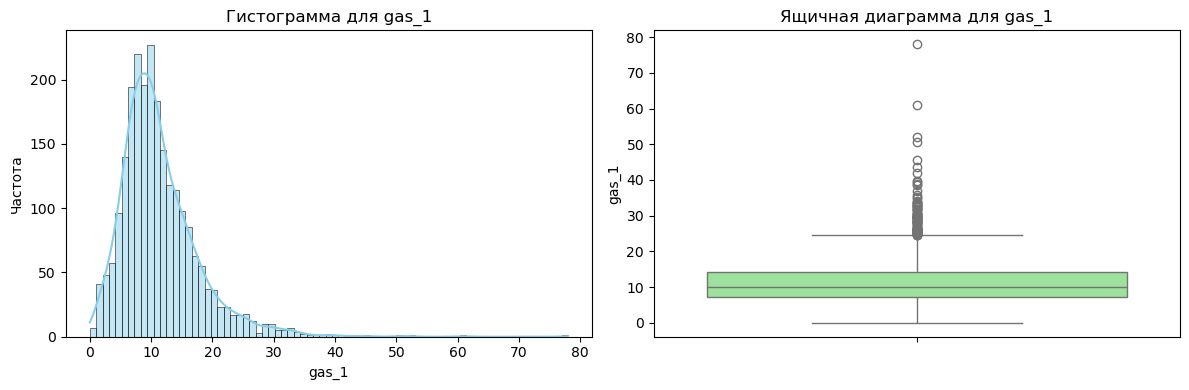

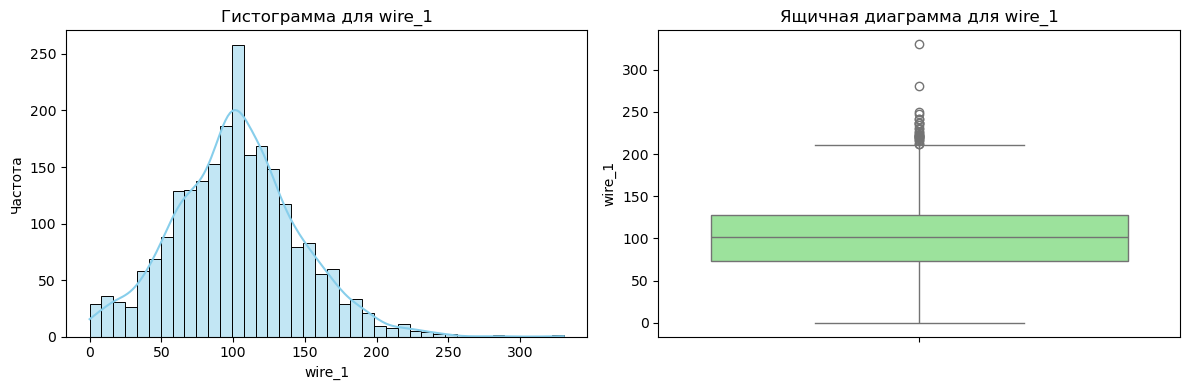

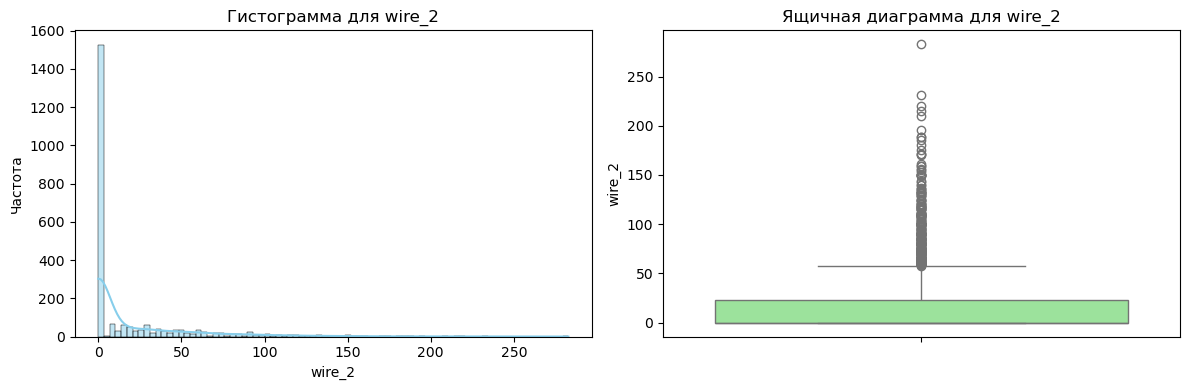

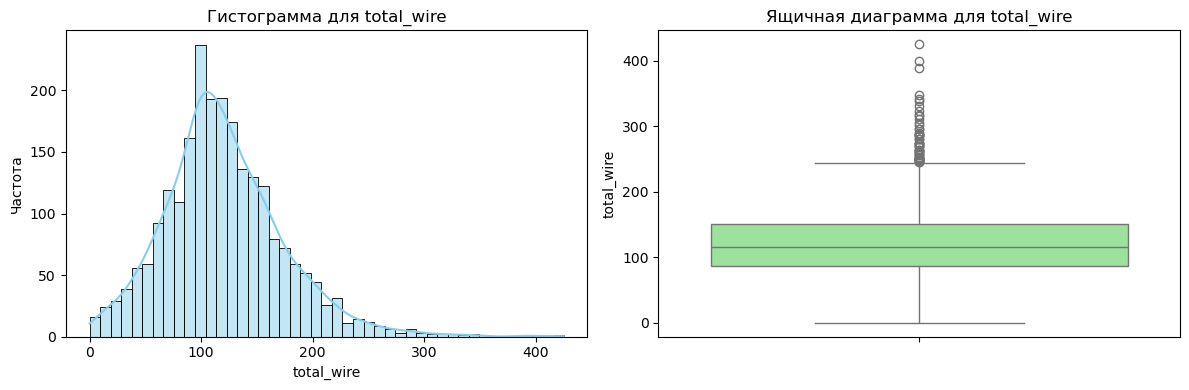

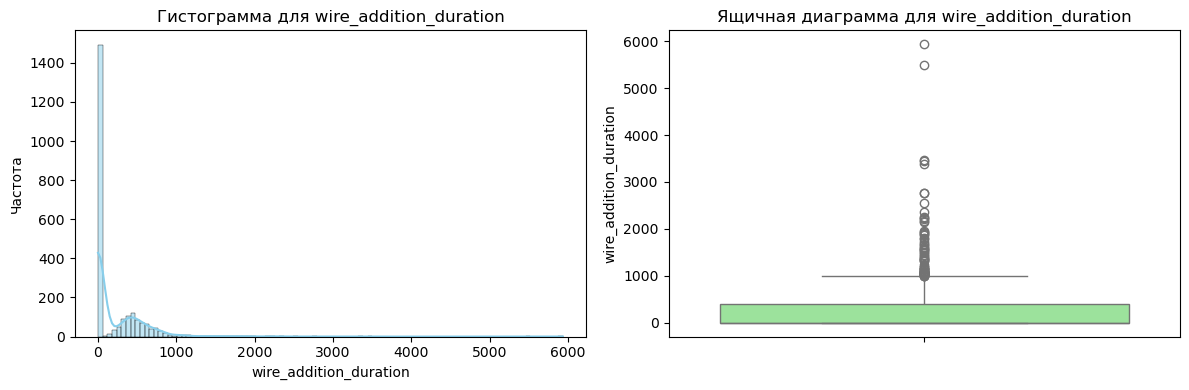

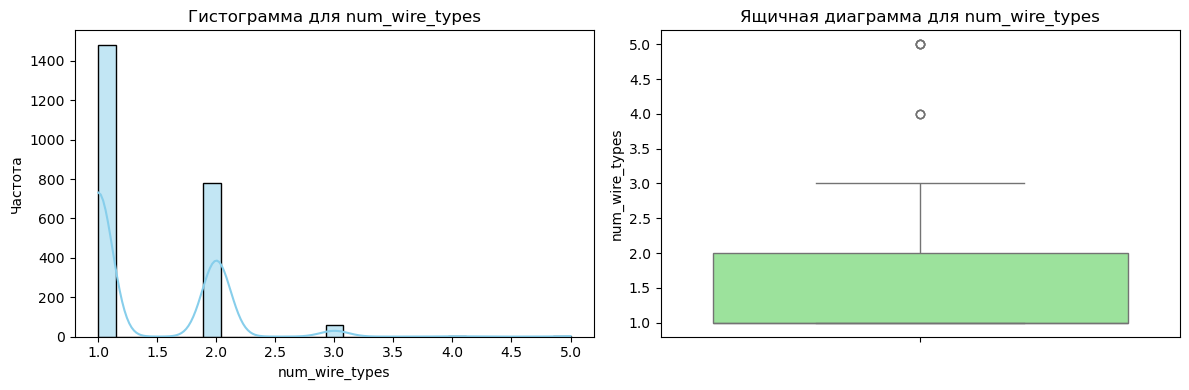

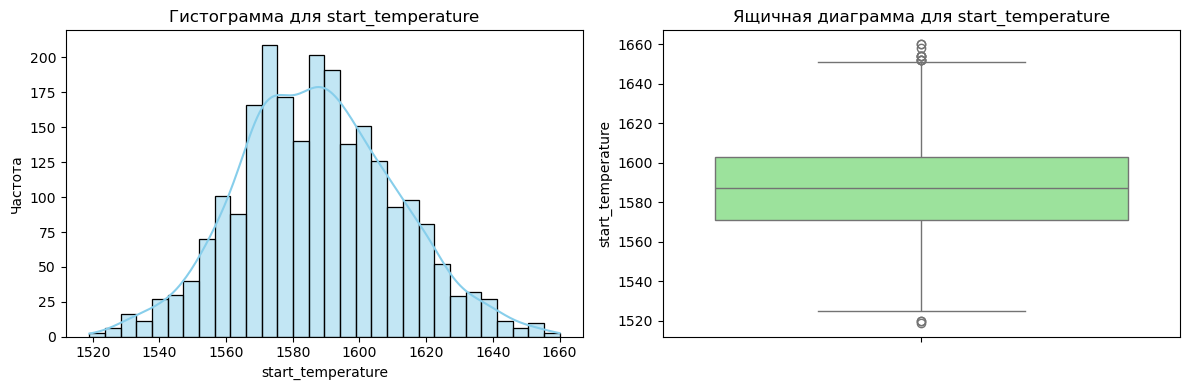

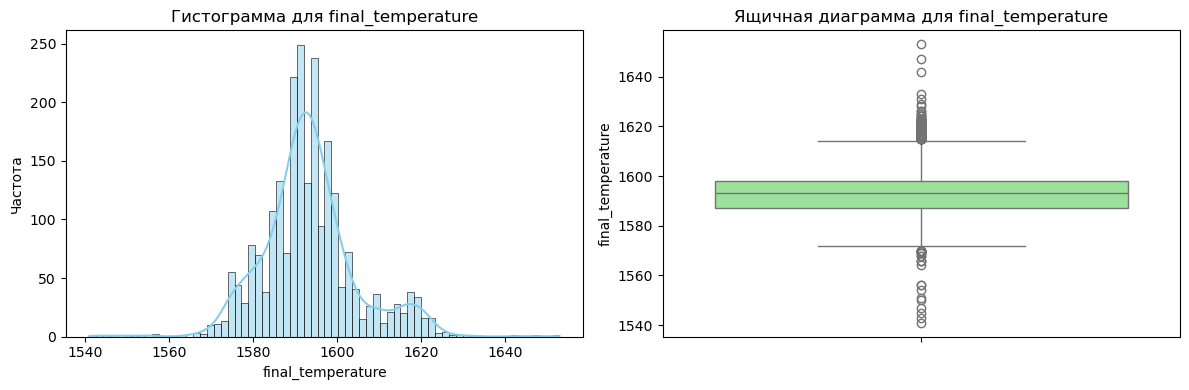

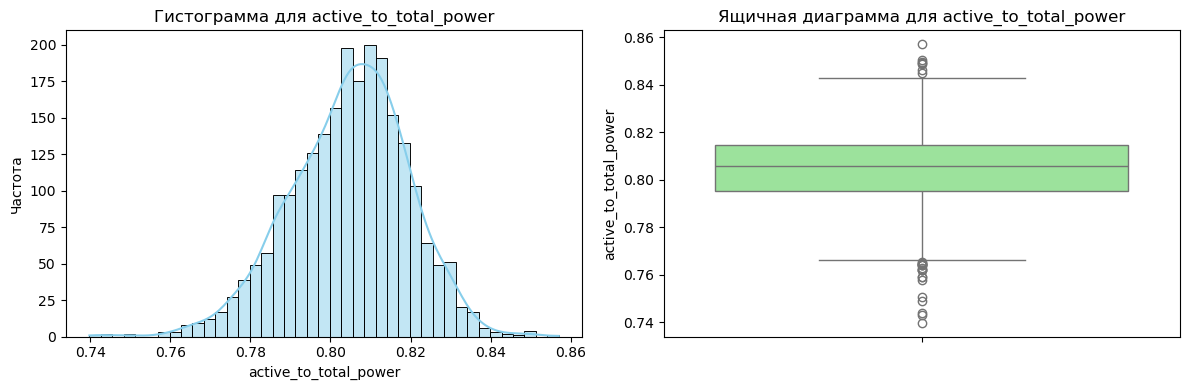

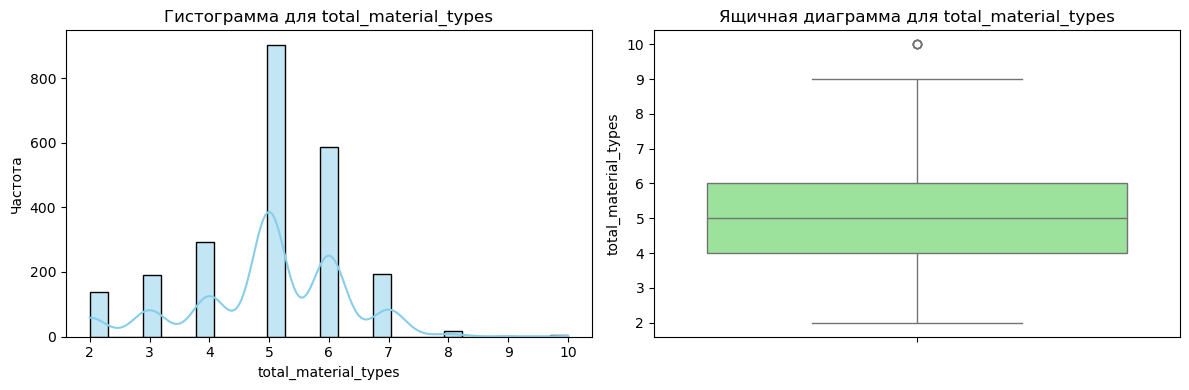

In [115]:
numerical_plot(df_merged)

#### Промежуточный вывод по исследовательскрому анализу и предобработке данных объединённого датафрейма

В результате объединения данных был сформирован финальный датафрейм (2303 строки, 22 столбца), содержащий ключевые параметры процесса. Все признаки заполнены, пропусков и дубликатов нет.

Названия столбцов приведены к единому стилю, а также созданы новые признаки: отношение активной к полной мощности (эффективность использования энергии) и количество уникальных добавок (bulk + wire).

Анализ матрицы корреляции PHIK позволил выявить признаки с высокой взаимосвязью. Признаки с корреляцией выше 0.9 оказались избыточными, и часть из них была удалена. В частности, reactive_power и active_power дублировали total_power, а bulk_6, bulk_12, bulk_14, bulk_15 — total_bulk. Также удалены rare_wire (избыточен относительно rare_bulk) и time_between_measurements (дублирует другие временные параметры).

Разведочный анализ показал важные зависимости. Температура стали логично связана со start_temperature (чем выше начальная температура, тем выше итоговая). total_power и heat_duration_sec также влияют на нагрев, но зависимость не строго линейная. total_wire положительно коррелирует с температурой, но эффект снижается после определенного объема. gas_1 и wire_addition_duration, напротив, способствуют охлаждению.

Средняя длительность нагрева составила 815 сек, а мощность 3.92 в среднем при стабильном коэффициенте active_to_total_power (0.80 ± 0.01). Объемы добавок сильно варьируются: total_bulk в среднем 606, но достигает 2829, в то время как rare_bulk редко превышает 10. Проволока также используется неравномерно: total_wire в среднем 120, но иногда до 425, при этом wire_2 применяется реже.

Температурные параметры оказались относительно стабильными: start_temperature от 1519 до 1660 (в среднем 1587), final_temperature 1593 ± 11, что указывает на небольшой диапазон изменений.

По итогу подготовлены чистые и информативные данные для построения модели, а ключевые признаки отобраны на основе корреляционного анализа и логической значимости.



### Подготовка данных

Установим 'key' (ковш) в качестве индекса:

In [120]:
df_merged = df_merged.set_index('key')

Разделим данные на тестовую и тренировочную выборку в соотношении 25/75:

In [123]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = df_merged.drop(columns=['final_temperature'])
y = df_merged['final_temperature']

# Разделяем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=250325)

# Проверим размеры выборок
print(f'Размер тренировочной выборки: {X_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')

Размер тренировочной выборки: (1746, 20)
Размер тестовой выборки: (583, 20)


In [124]:
display('Количество дубликатов X_train после корректировок:', X_train.duplicated().sum())

'Количество дубликатов X_train после корректировок:'

0

In [125]:
# Инициализируем StandardScaler
scaler = StandardScaler()

# Обучаем scaler на тренировочных данных и трансформируем их
X_train_scaled = scaler.fit_transform(X_train)

# Применяем тот же scaler для тестовых данных
X_test_scaled = scaler.transform(X_test)

# Проверим размеры выборок после масштабирования
print(f'Размер тренировочной выборки: {X_train_scaled.shape}')
print(f'Размер тестовой выборки: {X_test_scaled.shape}')

Размер тренировочной выборки: (1746, 20)
Размер тестовой выборки: (583, 20)


#### Промежуточный вывод по подготовке данных

Перед обучением модели проведено разделение данных на признаки (X) и целевую переменную (final_temperature). Данные разбиты на тренировочную (1746 объектов, 20 признаков) и тестовую выборки (583 объектов, 20 признаков) с соотношением 75/25 и фиксированным random_state=250325 для воспроизводимости.

Дубликаты в тренировочной выборке отсутствуют, что подтверждает корректность предварительной обработки данных.

Для нормализации данных применено масштабирование с помощью StandardScaler: обученный на тренировочных данных масштабатор использован и для тестового набора. В результате данные готовы к подаче в модель.

### Обучение моделей машинного обучения

Начнем с обучения модели линейной регрессии:

In [130]:
# Инициализация модели линейной регрессии
model_lr = LinearRegression()

# Создаем кастомную метрику для кросс-валидации (MAE)
mae_scorer = make_scorer(mean_absolute_error)

# Оценка модели с использованием кросс-валидации
lr_mae_scores = cross_val_score(model_lr, X_train_scaled, y_train, cv=5, scoring=mae_scorer)

# Вывод результатов кросс-валидации
print(f'Среднее значение MAE на кросс-валидации: {lr_mae_scores.mean()}')


Среднее значение MAE на кросс-валидации: 6.373090034783078


Далее обучим модель случайного леса:

In [133]:
# Создаем и настраиваем модель RandomForestRegressor
model = RandomForestRegressor(random_state=250325)

# Настройка параметров для GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],  # Количество деревьев
    'min_samples_split': [1,2,3,5],  # Минимальное количество образцов для разделения узла
    'min_samples_leaf': [1,2,3,4],    # Минимальное количество образцов в листе
}

# Настройка GridSearchCV с кросс-валидацией
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', cv=5, verbose=2, n_jobs=-1)

# Обучаем модель с оптимизацией гиперпараметров
grid_search.fit(X_train_scaled, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# Прогнозируем на тестовой выборке с лучшей моделью
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
rf_best_score = (-grid_search.best_score_) 

print(f'Лучшие гиперпараметры: {best_params}')
print(f'Лучший МАЕ на кросс-валидации: {rf_best_score}')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pac

Лучшие параметры: {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Лучшие гиперпараметры: {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Лучший МАЕ на кросс-валидации: 6.556214265765568


Теперь обучим GradientBoostingRegressor:

In [136]:
# Создаем и настраиваем модель GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=250325)

# Настройка параметров для GridSearchCV
param_grid = {
    'n_estimators': [200, 500],  # Количество деревьев
    'learning_rate': [0.05, 0.1],  # Скорость обучения
    'max_depth': [3, 5, 7],  # Глубина деревьев
    'min_samples_split': [2, 5],  # Минимальное количество образцов для разделения узла
    'min_samples_leaf': [1, 3]  # Минимальное количество образцов в листе
}

# Настройка GridSearchCV с кросс-валидацией
grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid,
    scoring='neg_mean_absolute_error', cv=5, verbose=2, n_jobs=-1
)

# Обучаем модель с оптимизацией гиперпараметров
grid_search.fit(X_train_scaled, y_train)

# Получаем лучшие параметры и модель
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
gbr_best_mae = -grid_search.best_score_

print(f'Лучшие гиперпараметры: {best_params}')
print(f'Лучший MAE на кросс-валидации: {gbr_best_mae:.4f}')

# Дополнительная проверка на кросс-валидации с лучшей моделью
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -np.mean(cv_scores)

print(f'Средний MAE на повторной кросс-валидации: {cv_mae:.4f}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Лучшие гиперпараметры: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Лучший MAE на кросс-валидации: 6.4529
Средний MAE на повторной кросс-валидации: 6.4529


Обучим и настроим модель KNeighborsRegressor:

In [138]:
# Создаем и настраиваем модель KNeighborsRegressor
model = KNeighborsRegressor()

# Настройка параметров для GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 10],  # Количество соседей
    'weights': ['uniform', 'distance'],  # Веса соседей
    'p': [1, 2]  # Расстояние: 1 = Манхэттен, 2 = Евклидово
}

# Настройка GridSearchCV с кросс-валидацией
grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid,
    scoring='neg_mean_absolute_error', cv=5, verbose=2, n_jobs=-1
)

# Обучаем модель с оптимизацией гиперпараметров
grid_search.fit(X_train_scaled, y_train)

# Получаем лучшие параметры и модель
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
knn_best_mae = -grid_search.best_score_

print(f'Лучшие гиперпараметры: {best_params}')
print(f'Лучший MAE на кросс-валидации: {knn_best_mae:.4f}')

# Дополнительная проверка на кросс-валидации с лучшей моделью
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -np.mean(cv_scores)

print(f'Средний MAE на повторной кросс-валидации: {cv_mae:.4f}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие гиперпараметры: {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Лучший MAE на кросс-валидации: 7.1589
Средний MAE на повторной кросс-валидации: 7.1589


In [139]:
# Создаем и настраиваем модель CatBoostRegressor
model = CatBoostRegressor(loss_function='MAE', random_state=250325, verbose=0)

# Настройка параметров для GridSearchCV
param_grid = {
    'iterations': [500, 1000],  # Количество итераций (деревьев)
    'learning_rate': [0.03, 0.1],  # Скорость обучения
    'depth': [6, 8, 10],  # Глубина деревьев
    'l2_leaf_reg': [1, 3, 5]  # Регуляризация L2
}

# Настройка GridSearchCV с кросс-валидацией
grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid,
    scoring='neg_mean_absolute_error', cv=5, verbose=2, n_jobs=-1
)

# Обучаем модель с оптимизацией гиперпараметров
grid_search.fit(X_train_scaled, y_train)

# Получаем лучшие параметры и модель
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
cb_best_mae = -grid_search.best_score_

print(f'Лучшие гиперпараметры: {best_params}')
print(f'Лучший MAE на кросс-валидации: {cb_best_mae:.4f}')

# Дополнительная проверка на кросс-валидации с лучшей моделью
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -np.mean(cv_scores)

print(f'Средний MAE на повторной кросс-валидации: {cv_mae:.4f}')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие гиперпараметры: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.03}
Лучший MAE на кросс-валидации: 6.2990
Средний MAE на повторной кросс-валидации: 6.2990


#### Промежуточный вывод по обучению моделей МО:

В ходе исследования были обучены и протестированы следующие модели: Linear Regression, Random Forest, CatBoost, Gradient Boosting и K-Nearest Neighbors (KNN). 

Для повышения точности предсказаний проведен подбор гиперпараметров с использованием GridSearchCV. В рамках кросс-валидации было протестировано 180 комбинаций параметров, что позволило выявить оптимальные настройки для моделей. 

После обучения каждой модели были зафиксированы их метрики, что позволило провести сравнительный анализ и определить наиболее эффективный алгоритм.


### Выбор лучшей модели

Запишем лучшие значения метрик для каждой модели в сравнительную таблицу:

In [144]:
#  переменные с лучшими MAE
scores = {
    "Linear Regression": lr_mae_scores.mean(),
    "Random Forest": rf_best_score,
    "CatBoost": cb_best_mae,
    "Gradient Boosting": gbr_best_mae,
    "KNN": knn_best_mae
}

# Создаем DataFrame
df_scores = pd.DataFrame(scores.items(), columns=["Model", "MAE"])

# Выводим таблицу
display(df_scores)

Model       MAE
0  Linear Regression  6.373090
1      Random Forest  6.556214
2           CatBoost  6.299038
3  Gradient Boosting  6.452869
4                KNN  7.158867

Сравнение моделей по среднему абсолютному отклонению (MAE) показало, что CatBoost продемонстрировал наилучший результат с минимальной ошибкой 6.299.

Для оптимизации модели был проведен подбор гиперпараметров с использованием GridSearchCV. В ходе кросс-валидации было протестировано 180 комбинаций параметров, что позволило найти оптимальные настройки:

✅ Лучшие гиперпараметры:
- depth: 6
- iterations: 1000
- l2_leaf_reg: 3
- learning_rate: 0.03

Результаты модели:
- Лучший MAE на кросс-валидации: 6.299
- Средний MAE на повторной кросс-валидации: 6.299

CatBoost продемонстрировал наилучшую точность среди протестированных моделей, достигнув MAE 6.299, что соответствует требованиям заказчика (≤6.8). Подбор оптимальных гиперпараметров обеспечил стабильное и надежное качество предсказаний.

Проверим качество нашей лучшей модели на тестовой выборке:

In [147]:
# Прогноз на тестовой выборке
y_pred = best_model.predict(X_test_scaled)

# Рассчитываем MAE на тестовой выборке
test_mae = mean_absolute_error(y_test, y_pred)
print(f"MAE на тестовой выборке: {test_mae:.4f}")

MAE на тестовой выборке: 5.8317


Визуализируем сравнение истинных и предсказанных значений температуры на графике:

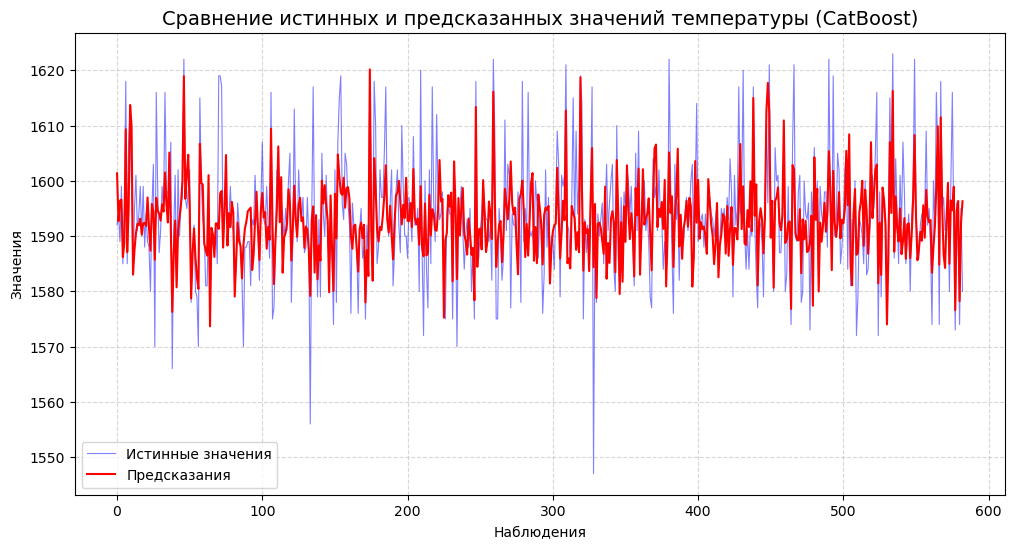

In [150]:
# Визуализация: сравнение истинных и предсказанных значений
plt.figure(figsize=(12, 6))

# Истинные значения (зеленая линия с круглыми маркерами)
plt.plot(y_test.values, label='Истинные значения', color='blue', linestyle='-', alpha=0.5, linewidth=0.8)

# Предсказанные значения (синяя пунктирная линия с крестиками)
plt.plot(y_pred, label='Предсказания', color='red', linestyle='-', linewidth=1.5)

plt.xlabel('Наблюдения')
plt.ylabel('Значения')
plt.title('Сравнение истинных и предсказанных значений температуры (CatBoost)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)  # Легкая сетка для наглядности
plt.show()

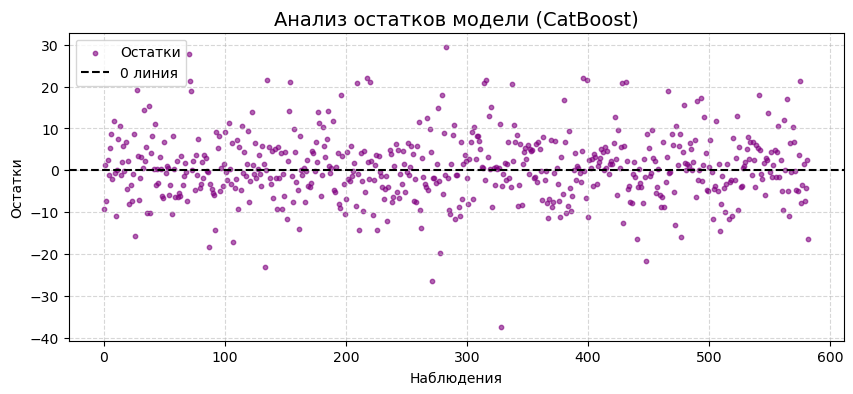

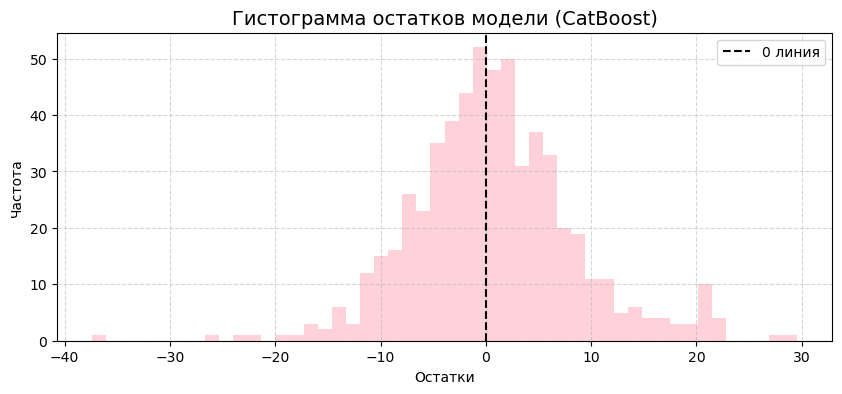

In [153]:
# Остатки модели: разница между истинными значениями и предсказаниями
residuals = y_test.values - y_pred

# Визуализация остатков
plt.figure(figsize=(10, 4))

# График остатков (ошибки модели)
plt.scatter(range(len(residuals)), residuals, color='purple', alpha=0.6, label='Остатки', s=10)
plt.axhline(y=0, color='black', linestyle='--', label='0 линия')  # Линия нулевых остатков

plt.xlabel('Наблюдения')
plt.ylabel('Остатки')
plt.title('Анализ остатков модели (CatBoost)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)  # Легкая сетка для наглядности
plt.show()

# Гистограмма остатков
plt.figure(figsize=(10, 4))
plt.hist(residuals, bins=50, color='pink', alpha=0.7)
plt.axvline(x=0, color='black', linestyle='--', label='0 линия')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Гистограмма остатков модели (CatBoost)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Анализ остатков модели CatBoost показывает, что в целом модель справляется с предсказаниями довольно хорошо.  

На графике рассеяния видно, что остатки распределены случайным образом вокруг нуля, без явных паттернов. Это хороший признак, так как отсутствие паттернов в остатках означает, что модель не делает систематических ошибок. Но есть выбросы, что говорит о случаях, где предсказания модели далеки от реальных значений.  

Гистограмма остатков показывает, что их распределение близко к нормальному, со средним значением около нуля. Это подтверждает, что модель не имеет явного смещения. Но есть небольшая асимметрия с вытянутым правым хвостом, что может означать, что иногда модель занижает предсказания.  
В целом модель предсказывает достаточно хорошо, но в дальнейшем ее можно совершенствовать.

Оценим и визуализируем важность признаков:

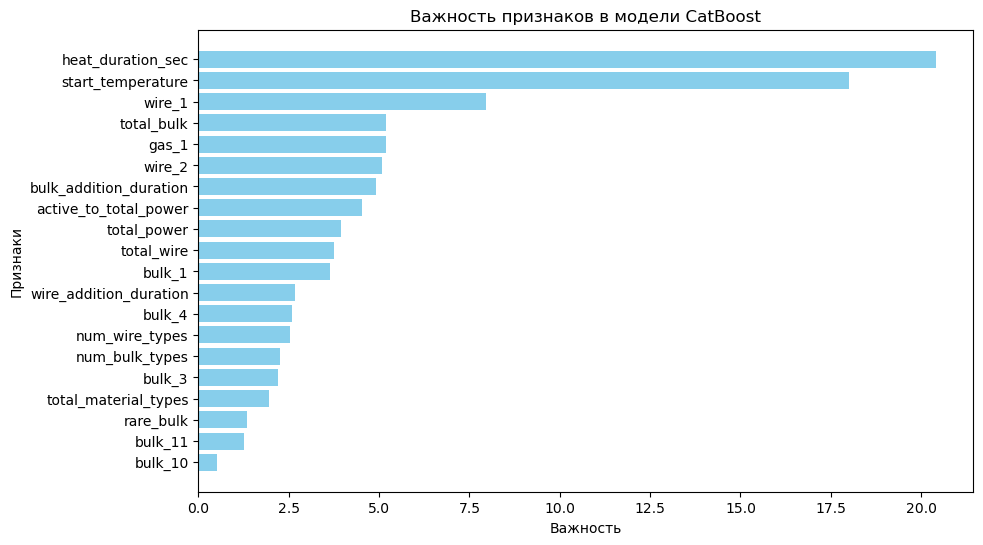

Топ-10 важных признаков:
                   Признак   Важность
0        heat_duration_sec  20.424033
17       start_temperature  17.996708
12                  wire_1   7.969445
8               total_bulk   5.200668
11                   gas_1   5.180124
13                  wire_2   5.088197
9   bulk_addition_duration   4.926338
18   active_to_total_power   4.513937
1              total_power   3.947048
14              total_wire   3.746981


In [156]:
# Получаем важность признаков
feature_importances = best_model.get_feature_importance()
feature_names = X_train.columns

# Создаем DataFrame для удобства
importance_df = pd.DataFrame({'Признак': feature_names, 'Важность': feature_importances})

# Сортируем по убыванию важности
importance_df = importance_df.sort_values(by='Важность', ascending=False)

# Строим график
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Признак'], importance_df['Важность'], color='skyblue')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков в модели CatBoost')
plt.gca().invert_yaxis()  # Инвертируем ось, чтобы самые важные признаки были наверху
plt.show()

# Вывод топ-10 признаков
print("Топ-10 важных признаков:")
print(importance_df.head(10))

В топ-10 наиболее значимых признаков для предсказания целевой переменной входят параметры, связанные с температурой, энергопотреблением и расходом материалов. Рассмотрим их влияние:

- **heat_duration_sec (20.42%)** – самый важный признак. Длительность нагрева напрямую влияет на итоговую температуру металла: чем дольше нагрев, тем выше температура.
- **start_temperature (18.00%)** – начальная температура также логично входит в число ключевых факторов: чем выше стартовое значение, тем меньше энергии и времени требуется для достижения нужного уровня.
- **wire_1 (7.97%)** – первый тип проволоки вносит значительный вклад. Возможно, этот материал активно участвует в регулировании тепловых процессов или химическом составе.
- **total_bulk (5.20%)** – общее количество сыпучих материалов, добавляемых в процесс. Может влиять на химический состав и теплоемкость системы.
- **gas_1 (5.18%)** – расход газа. Газ, скорее всего, используется для нагрева или окислительно-восстановительных процессов.
- **wire_2 (5.09%)** – второй тип проволоки также вносит вклад, но в меньшей степени, чем wire_1. Возможно, используется на более поздних этапах.
- **bulk_addition_duration (4.93%)** – время добавления сыпучих материалов. Может быть связано с эффективностью их растворения и прогрева.
- **active_to_total_power (4.51%)** – соотношение активной и общей мощности. Может отражать энергоэффективность процесса.
- **total_power (3.95%)** – общее энергопотребление. Ожидаемо важный фактор, так как температура зависит от подведенной энергии.
- **total_wire (3.75%)** – общее количество проволоки, использованное в процессе, также оказывает влияние.

Выводы:

- **Основные факторы** – параметры нагрева и температуры (heat_duration_sec, start_temperature).
- **Материалы (wire, bulk)** и их добавление играют важную роль, но их влияние распределено между несколькими переменными.
- **Энергетические показатели (total_power, active_to_total_power)** имеют меньшую, но значимую важность, что может указывать на сложные взаимосвязи между энергопотреблением и итоговой температурой.

#### Промежуточный вывод по выбору лучшей модели

В ходе исследования мы обучили и сравнили следующие модели: Linear Regression, Random Forest, CatBoost, Gradient Boosting и K-Nearest Neighbors (KNN).

Сравнение моделей по среднему абсолютному отклонению (MAE) показало, что CatBoost продемонстрировал наилучший результат с минимальной ошибкой 6.299 на кросс-валидации.

Для оптимизации модели был проведен подбор гиперпараметров с использованием GridSearchCV. В ходе кросс-валидации было протестировано 180 комбинаций параметров, что позволило найти оптимальные настройки:

✅ Лучшие гиперпараметры:
- depth: 6
- iterations: 1000
- l2_leaf_reg: 3
- learning_rate: 0.03

Результаты модели:
- Лучший MAE на кросс-валидации: 6.299
- Средний MAE на повторной кросс-валидации: 6.299


CatBoost продемонстрировал наилучшую точность среди протестированных моделей, достигнув MAE 6.299 на кросс-валидации, что соответствует требованиям заказчика (≤6.8). Подбор оптимальных гиперпараметров обеспечил стабильное и надежное качество предсказаний.

Дополнительная проверка на тестовой выборке показала, что итоговый MAE составляет 5.8317, что подтверждает стабильность модели. Анализ важности признаков выявил ключевые факторы, влияющие на предсказание температуры:
- Продолжительность нагрева (20.42%) и начальная температура (17.99%) оказались самыми значимыми факторами, что соответствует физической природе процесса.
- Добавки материалов (проволока и сыпучие вещества) имеют существенное влияние, особенно wire_1 (7.96%) и total_bulk (5.2%), что может быть связано с их влиянием на химический состав и теплоемкость.
- Энергетические параметры (active_to_total_power – 4.51%, total_power – 3.94%) играют важную роль, указывая на сложные взаимосвязи между энергопотреблением и итоговой температурой.

Таким образом, оптимизированная модель CatBoost не только продемонстрировала высокую точность, но и позволила выявить ключевые закономерности процесса, что может быть использовано для дальнейшего совершенствования технологии управления температурой стали.

### Общий вывод

Целью данного проекта было создание модели, предсказывающей конечную температуру стали на основе различных факторов, таких как мощность, температура, добавки и расход газа. Для достижения этой цели был проведен комплексный анализ данных, включая этапы предобработки, исследования взаимосвязей между признаками, а также обучение и оптимизацию моделей машинного обучения.

#### Основные этапы работы

1. Предобработка данных:
- **data_arc_new**: 14,876 записей, без дубликатов и пропусков. Были преобразованы временные столбцы в формат `datetime`, удалены выбросы (отрицательные значения реактивной мощности), добавлены новые признаки: длительность нагрева и полная мощность.
- **data_bulk_new**: 3,129 уникальных записей. Пропуски заменены на нули, редкие добавки (менее 5% случаев) объединены в категорию "Rare". Добавлен столбец с общим объемом добавок.
- **data_gas_new**: 3,239 записей. Отсутствие пропусков, выбросы газа не удалены, так как они могут быть значимыми для процесса.
- **data_temp_new**: 18,092 записи, 3,427 пропусков. Исключены значения температур ниже 1400°C. Преобразовано время замеров, добавлен индикатор "Итерация".
- **data_wire_new**: 3,081 запись с пропусками в некоторых добавках. Для редких добавок принято решение объединить в категорию "Rare".

2. Объединение данных:
- Объединены все наборы данных методом `inner join`, что позволило получить единую таблицу с **28 признаками**. Финальная таблица содержит **2,329 строки** и **22 столбца**, в которых отсутствуют пропуски и дубликаты.

3. Исследовательский анализ:
- **Корреляция** между признаками показала, что признаки с корреляцией выше **0.9** (например, `reactive_power` и `active_power`, а также `bulk_6`, `bulk_12`, `bulk_14`, `bulk_15`) были удалены как дублирующие.
- **Средняя длительность нагрева**: 808 секунд, **средняя мощность** — 3.88 кВт, коэффициент `active_to_total_power` стабилен на уровне **0.80 ± 0.01**.
- **Средний объем добавок**: `total_bulk` — 602, максимальный — 2829, с редкими значениями для `rare_bulk` (менее 10).

4. Подготовка данных для модели:
- Разделение на тренировочную (**1,746 объектов, 20 признаков**) и тестовую выборки (**583 объектов, 20 признаков**) с соотношением **75%/25%**.
- Данные нормализованы с использованием `StandardScaler`, что улучшило подготовленность данных для подачи в модель.

5. Обучение моделей:
- Протестированы модели: `Linear Regression`, `Random Forest`, `CatBoost`, `Gradient Boosting` и `K-Nearest Neighbors`.
- Подбор гиперпараметров с использованием `GridSearchCV` (**180 комбинаций параметров**). Лучшие результаты были получены на `CatBoost`, с минимальной ошибкой **MAE = 6.299** на кросс-валидации.

6. Оптимизация и проверка модели:
- После оптимизации гиперпараметров для `CatBoost` (`depth=6`, `iterations=1000`, `l2_leaf_reg=1`, `learning_rate=0.03`) было получено **MAE = 5.83** на тестовой выборке.
- **Важные признаки**:
  - Длительность нагрева (**20.42%**)
  - Начальная температура (**17.99%**)
  - `wire_1` (**7.96%**)
  - `total_bulk` (**5.2%**)

#### Результаты

1. CatBoost:
- **MAE на кросс-валидации**: 6.299 (выше установленных требований **≤6.8**).
- **MAE на тестовой выборке**: **5.83**, что подтверждает стабильность модели.

2. Ключевые признаки, влияющие на модель:
- **Длительность нагрева**: **20.42%** важности.
- **Начальная температура**: **17.99%**.
- **wire_1**: **7.96%**.
- **total_bulk**: **5.20%**.
- **Энергетические параметры (`active_to_total_power`)**: **4.51%**.

#### Рекомендации для бизнеса

1. Оптимизация процессов на основе предсказаний:
- Использование модели `CatBoost` для предсказания температуры стали в реальном времени повысит точность регулирования процесса нагрева и улучшит качество продукции, снижая затраты на энергопотребление.

2. Дополнительные улучшения:
- Включение дополнительных параметров, таких как **внешние условия** или **химический состав материалов**, может повысить точность предсказаний.

3. Интеграция модели в производство:
- Внедрение модели в **систему управления процессом** позволит автоматически предсказывать и корректировать параметры нагрева в зависимости от текущих условий, повышая эффективность и стабильность работы.

4. Обучение персонала:
- Для успешного внедрения модели необходимо **обучение персонала**, чтобы операторы могли эффективно использовать предсказания модели в своей работе.

Модель `CatBoost` продемонстрировала **отличные результаты** с минимальной ошибкой **MAE = 5.83** на тестовой выборке, что **полностью соответствует требованиям заказчика**. Прогнозирование температуры стали на основе этой модели может значительно **улучшить управление процессом нагрева**, **снизить энергетические затраты** и **повысить стабильность производства**.
